In [1]:
#Import Packages
import ROOT as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import pickle
import scipy
import numba
from numba import jit
#Specific Functions
from matplotlib.colors import LogNorm
from matplotlib.font_manager import FontProperties
from scipy.signal import argrelextrema
# For plots
%matplotlib inline
from scipy.stats import gaussian_kde

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f_ug8gkv because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


import torch_geometric

In [2]:
def Shower_Clustering(Shower_l, Shower_t, Shower_r):
    #Define Centers
    Shower_Centers = np.array([[-5.28,0.00,5.28], # X
                               [-3.05,6.10,-3.05], # Y
                               [3,3,3]]) #Z
    
    #Shower Modules
    #Adjust Based on MIP for Run
    Shower_MIPs = [37.5,37.5,37.5]
    Modules = np.column_stack([Shower_l/Shower_MIPs[0], Shower_t/Shower_MIPs[1], Shower_r/Shower_MIPs[2]])
    
    #Calculations
    m_logWeightBase=3.6 #Wighting parameter
    Shower_Sums = Modules.sum(axis=1) #Get shower sum
    test_weights = m_logWeightBase + np.log((Modules+0.0001)/Shower_Sums[:,None]) #Get initial weights in 3-column array
    weights = test_weights*(test_weights > 0) #Check weights by keeping calculated weights > 0, which makes the rest 0
    weight_sums = weights.sum(axis=1) #Sum weights over 3 axes
    
    #Calc Shower Centers
    x = (Shower_Centers[0,:] * weights).sum(axis=1)
    y = (Shower_Centers[1,:] * weights).sum(axis=1)
    z = (Shower_Centers[2,:] * weights).sum(axis=1)

    #Calc weighted centers
    Sh_x =  x / weight_sums
    Sh_y =  y / weight_sums
    Sh_z =  z / weight_sums
    
    return Sh_x, Sh_y, Sh_z


"/volatile/halla/solid/tianye/container/HallC_beamtest_18deg_simulation_files/"

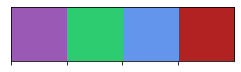

In [3]:
best_colors = ["#9b59b6", "#2ecc71", "cornflowerblue","firebrick"]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

datafile0 = "/volatile/halla/solid/tianye/container/HallC_beamtest_18deg_simulation_files/HallC_beamtest_eAll_LD2_18deg_filenum9991_9.991e8_10.6GeV_shielding_30x30x2.5cm3_poly_beamline_reduce_tree_rate_40uA_Q210MeV_Npe.root"

upfile = uproot.open(datafile0)
upfile.keys()

## Import Sim

In [4]:
%%time

ele_Sim =  pd.read_pickle("SavedSim_Pencil/ele.pkl").copy()
gamma_Sim =  pd.read_pickle("SavedSim_Pencil/gamma.pkl").copy()
pim_Sim =  pd.read_pickle("SavedSim_Pencil/pim.pkl").copy()
bkg_Sim = pd.read_pickle("SavedSim_Pencil/BeamOnTarget.pkl").copy()

raw_sim_df = ele_Sim.append([gamma_Sim, pim_Sim], ignore_index=1).copy()
raw_sim_df["theta"] = np.arccos(raw_sim_df["pz"]/raw_sim_df["p"]) * (180/np.pi)
sim_df = raw_sim_df#[((raw_sim_df["theta"]>17) & (raw_sim_df["theta"]<19)) ].copy()

#Remove extra
del ele_Sim, gamma_Sim, pim_Sim


CPU times: user 5min 58s, sys: 50 s, total: 6min 47s
Wall time: 6min 46s


In [5]:
31268.761719/0.0003

104229205.73

In [6]:
#Adjust Rate
sim_df["rate"][sim_df["pid"]==-211] = 20
sim_df["rate"][sim_df["pid"]==11] = 0.0003

sim_df

<ipython-input-6-88d3c18eccf2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df["rate"][sim_df["pid"]==-211] = 20
<ipython-input-6-88d3c18eccf2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df["rate"][sim_df["pid"]==11] = 0.0003


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_y,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta
0,0.0003,0.0,0.0,0.0,-0.234481,2.871560e-17,0.721657,0.758795,11,743.066040,...,"[0.48136964440345764, 0.4120079278945923, 0.99...","[0.48136964440345764, 0.4120079278945923, 0.99...","[-673.2610473632812, -673.1115112304688, -673....",0.000904,0.000904,0.000904,0.036460,33.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 6.0, 2.0, 1.0, ...",18.000007
1,0.0003,0.0,0.0,0.0,-2.981923,3.651803e-16,9.177417,9.649707,11,6910.143066,...,"[-0.42328163981437683, -0.2299025058746338, -0...","[-0.42328163981437683, -0.2299025058746338, -0...","[-671.9962158203125, -672.5142211914062, -672....",0.002967,0.002967,0.002967,0.032077,34.0,"[0.0, 1.0, 2.0, 0.0, 0.0, 10.0, 7.0, 1.0, 0.0,...",17.999995
2,0.0003,0.0,0.0,0.0,-0.911992,1.116868e-16,2.806822,2.951267,11,2877.891602,...,"[0.4504014849662781, 0.45710650086402893, 0.88...","[0.4504014849662781, 0.45710650086402893, 0.88...","[-672.9779663085938, -672.8054809570312, -672....",0.000547,0.000547,0.000547,0.024543,16.0,"[0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 1.0, 0.0, 0.0, ...",17.999995
3,0.0003,0.0,0.0,0.0,-2.397427,2.936001e-16,7.378521,7.758236,11,7744.224609,...,"[-0.4792017340660095, -0.45561927556991577, -0...","[-0.4792017340660095, -0.45561927556991577, -0...","[-672.353271484375, -672.3509521484375, -672.3...",0.000286,0.000286,0.000286,0.020833,34.0,"[0.0, 4.0, 1.0, 0.0, 1.0, 9.0, 5.0, 0.0, 0.0, ...",17.999995
4,0.0003,0.0,0.0,0.0,-2.853923,3.495048e-16,8.783473,9.235490,11,7368.849121,...,"[0.2813042104244232, 3.444739580154419, 0.2057...","[0.2813042104244232, 3.444739580154419, 0.2057...","[-674.8857421875, -672.2174682617188, -674.846...",0.000818,0.000818,0.000818,0.026032,30.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...",17.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145903,20.0000,0.0,0.0,0.0,-1.573952,1.927535e-16,4.844126,5.093416,-211,5085.679688,...,[0.3960437476634979],[0.3960437476634979],[-671.8627319335938],0.000463,0.000463,0.000463,0.034769,6.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...",17.999995
5145904,20.0000,0.0,0.0,0.0,-2.191752,2.684122e-16,6.745520,7.092659,-211,7085.326660,...,[0.4454308748245239],[0.4454308748245239],[-673.2536010742188],0.000079,0.000079,0.000079,0.033819,18.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, ...",18.000007
5145905,20.0000,0.0,0.0,0.0,-1.127889,1.381266e-16,3.471285,3.649925,-211,3640.323242,...,[0.1406821608543396],[0.1406821608543396],[-672.0704345703125],0.000477,0.000477,0.000477,0.021713,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007
5145906,20.0000,0.0,0.0,0.0,-2.760364,3.380470e-16,8.495525,8.932724,-211,8924.052734,...,[-0.5401169657707214],[-0.5401169657707214],[-672.4806518554688],0.000736,0.000736,0.000736,0.029953,26.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 6.0, 3.0, 0.0, 0.0, ...",17.999995


##Export to CSV
all_sim = sim_df
#Get NCh
channel_list = [[] for _ in range(16)]
    
for row in all_sim["Cer"]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T
np.savetxt("Sim_CSV/Sim_Pencil_CherChannels_AllEvents.csv", Cer_array, delimiter=",")

all_sim["NCh"] = (Cer_array>0).sum(axis=1)


#Export to CSV
all_sim_np = (all_sim.iloc[:,list((all_sim.dtypes != object).values)]).to_numpy()
np.savetxt("Sim_CSV/Sim_Pencil_AllEvents.csv", all_sim_np, 
           header=','.join(list((all_sim.columns[((all_sim.dtypes != object).values)]).values)), 
           delimiter=",")


In [4]:
%%time
sim_df = pd.read_pickle("SavedSim_Pencil/Sample500k.pkl").copy()
bkg_Sim = pd.read_pickle("SavedSim_Pencil/BeamOnTarget.pkl").copy()
bkg_Sim["pid"] = 0

sim_df

CPU times: user 47.1 s, sys: 11.7 s, total: 58.8 s
Wall time: 58.8 s


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta,NCh
1271445,1.0,0.0,0.0,0.0,-1.749860,2.142961e-16,5.385516,5.662666,11,5652.867188,...,[0.43061283230781555],[-672.59765625],0.000489,0.000489,0.000489,0.033901,37.0,"[0.0, 1.0, 5.0, 0.0, 1.0, 10.0, 5.0, 1.0, 0.0,...",17.999995,10
1291198,1.0,0.0,0.0,0.0,-1.574065,1.927673e-16,4.844473,5.093781,11,5084.132324,...,"[-0.1973210871219635, -0.025781411677598953]","[-673.155517578125, -673.4472045898438]",0.000658,0.000658,0.000658,0.027569,33.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 6.0, 0.0, 2.0, ...",17.999995,8
3040514,1.0,0.0,0.0,0.0,-1.891029,2.315843e-16,5.819989,6.119498,22,6119.498535,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0
1664542,1.0,0.0,0.0,0.0,-1.646170,2.015977e-16,5.066392,5.327120,11,5315.209961,...,[0.16852334141731262],[-672.6641845703125],0.000500,0.000500,0.000500,0.042199,29.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 6.0, 5.0, 0.0, 0.0, ...",18.000007,8
718312,1.0,0.0,0.0,0.0,-2.578831,3.158158e-16,7.936827,8.345273,11,3980.122803,...,"[-0.3597544729709625, -0.39764633774757385, -0...","[-672.5665893554688, -672.49853515625, -672.54...",0.000505,0.000505,0.000505,0.026060,27.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 7.0, 0.0, 2.0, ...",17.999995,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4035089,1.0,0.0,0.0,0.0,-0.795842,9.746250e-17,2.449349,2.575398,-211,2570.215088,...,[-2.4318504333496094],[-669.1513061523438],0.001601,0.001601,0.001601,0.024468,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007,0
1954273,1.0,0.0,0.0,0.0,-0.430305,5.269720e-17,1.324343,1.392497,22,1392.497070,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0
3810076,1.0,0.0,0.0,0.0,-2.538567,3.108848e-16,7.812905,8.214974,-211,8206.588867,...,[0.2854882776737213],[-673.2467041015625],0.000446,0.000446,0.000446,0.034741,18.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...",18.000007,6
3270677,1.0,0.0,0.0,0.0,-0.188715,2.311092e-17,0.580805,0.610695,22,610.694641,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0


In [10]:
%%time
bkg_Sim = pd.read_pickle("SavedSim_Pencil/BeamOnTarget.pkl").copy()
bkg_Sim["pid"] = (0*bkg_Sim["pid"].values).astype(int)

#Get NCh
channel_list = [[] for _ in range(16)]
    
for row in bkg_Sim["Cer"]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T
#np.savetxt("Sim_CSV/Bkg_CherChannels_500k.csv", Cer_array, delimiter=",")

bkg_Sim["NCh"] = (Cer_array>0).sum(axis=1)

#Export Bkg
#bkg_Sim_np = (bkg_Sim.iloc[:,list((bkg_Sim.dtypes != object).values)]).to_numpy()
#np.savetxt("Sim_CSV/Sim_Pencil_Bkg.csv", bkg_Sim_np, 
#           header=','.join(list((bkg_Sim.columns[((bkg_Sim.dtypes != object).values)]).values)), 
#           delimiter=",")

bkg_Sim

CPU times: user 11 s, sys: 431 ms, total: 11.5 s
Wall time: 11.4 s


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_y,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,NCh
0,31268.761719,-0.150747,0.085143,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,31268.761719,-0.083738,0.091032,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,31268.761719,-0.125564,-0.089462,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,31268.761719,-0.133680,0.135885,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,31268.761719,-0.107184,-0.075538,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146963,31268.761719,-0.126608,-0.065543,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
146964,31268.761719,-0.013812,-0.221830,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
146965,31268.761719,0.009032,-0.032966,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
146966,31268.761719,-0.055848,-0.105311,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [6]:
sim_df[["rate","pid"]].groupby("pid").count()

,rate
pid,
-211,1560356
11,1819916
22,1620720


In [5]:
%%time

all_sim = sim_df

#Get NCh
channel_list = [[] for _ in range(16)]
    
for row in all_sim["Cer"]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T
np.savetxt("Sim_CSV/Sim_CherChannels.csv", Cer_array, delimiter=",")

all_sim["NCh"] = (Cer_array>0).sum(axis=1)

all_sim

CPU times: user 6.87 s, sys: 202 ms, total: 7.08 s
Wall time: 7.1 s


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta,NCh
1271445,1.0,0.0,0.0,0.0,-1.749860,2.142961e-16,5.385516,5.662666,11,5652.867188,...,[0.43061283230781555],[-672.59765625],0.000489,0.000489,0.000489,0.033901,37.0,"[0.0, 1.0, 5.0, 0.0, 1.0, 10.0, 5.0, 1.0, 0.0,...",17.999995,10
1291198,1.0,0.0,0.0,0.0,-1.574065,1.927673e-16,4.844473,5.093781,11,5084.132324,...,"[-0.1973210871219635, -0.025781411677598953]","[-673.155517578125, -673.4472045898438]",0.000658,0.000658,0.000658,0.027569,33.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 6.0, 0.0, 2.0, ...",17.999995,8
3040514,1.0,0.0,0.0,0.0,-1.891029,2.315843e-16,5.819989,6.119498,22,6119.498535,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0
1664542,1.0,0.0,0.0,0.0,-1.646170,2.015977e-16,5.066392,5.327120,11,5315.209961,...,[0.16852334141731262],[-672.6641845703125],0.000500,0.000500,0.000500,0.042199,29.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 6.0, 5.0, 0.0, 0.0, ...",18.000007,8
718312,1.0,0.0,0.0,0.0,-2.578831,3.158158e-16,7.936827,8.345273,11,3980.122803,...,"[-0.3597544729709625, -0.39764633774757385, -0...","[-672.5665893554688, -672.49853515625, -672.54...",0.000505,0.000505,0.000505,0.026060,27.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 7.0, 0.0, 2.0, ...",17.999995,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4035089,1.0,0.0,0.0,0.0,-0.795842,9.746250e-17,2.449349,2.575398,-211,2570.215088,...,[-2.4318504333496094],[-669.1513061523438],0.001601,0.001601,0.001601,0.024468,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007,0
1954273,1.0,0.0,0.0,0.0,-0.430305,5.269720e-17,1.324343,1.392497,22,1392.497070,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0
3810076,1.0,0.0,0.0,0.0,-2.538567,3.108848e-16,7.812905,8.214974,-211,8206.588867,...,[0.2854882776737213],[-673.2467041015625],0.000446,0.000446,0.000446,0.034741,18.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...",18.000007,6
3270677,1.0,0.0,0.0,0.0,-0.188715,2.311092e-17,0.580805,0.610695,22,610.694641,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0


## Get Sample Sim

In [32]:
%%time
#Get Sample
samp_sim = sim_df.sample(n=int(5e5), random_state=42)

#Pickle
name = "Sample500k"
samp_sim.to_pickle(f"SavedSim_Pencil/{name}.pkl")

#Export to CSV
samp_sim_np = (samp_sim.iloc[:,list((samp_sim.dtypes != object).values)]).to_numpy()
np.savetxt("Sim_CSV/Sim_Pencil_Sample500k.csv", samp_sim_np, 
           header=','.join(list((samp_sim.columns[((samp_sim.dtypes != object).values)]).values)), 
           delimiter=",")

samp_sim[["rate","pid"]].groupby("pid").count()

CPU times: user 58.7 s, sys: 11.1 s, total: 1min 9s
Wall time: 1min 9s


,rate
pid,
-211,161606
11,182076
22,156318


In [10]:
%%time
sim_np = (all_sim.iloc[:,list((all_sim.dtypes != object).values)]).to_numpy()
#sim_np = (all_sim.iloc[:,np.array(list((all_sim.dtypes != object).values)) + np.array(all_sim.columns=="Cer")]).to_numpy()

np.savetxt("Sim_CSV/Sim_Pencil.csv", sim_np, header=','.join(list((all_sim.columns[((all_sim.dtypes != object).values)]).values)), 
           delimiter=",")

CPU times: user 3min 31s, sys: 12.6 s, total: 3min 43s
Wall time: 3min 43s


## Overview

NameError: name 'raw_sim_df' is not defined

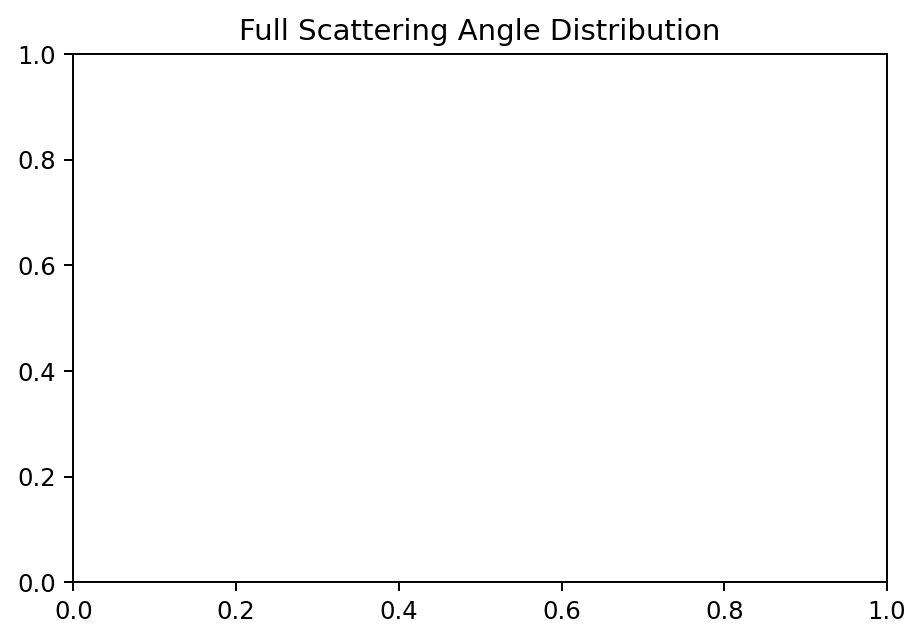

In [5]:
plt.figure(dpi=175)
plt.title("Full Scattering Angle Distribution")
sns.histplot(raw_sim_df, x="theta", binwidth=.01, hue="pid", element="step", lw=.5, #weights = "rate", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.2)

plt.xlabel("Scattering $\\theta^\circ$")
plt.yscale("log")
#plt.xticks(np.arange(0,45,1), minor=1)
#plt.savefig("Plots/NewCher_FullScatteringAngle.pdf")
plt.show()


plt.figure(dpi=175)
plt.title("Cut Scattering Angle Distribution - Scaled")
sns.histplot(all_sim, x="theta", binwidth=.01, hue="pid", element="step", weights = "rate", lw=0.5,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.2)

plt.xlabel("Scattering $\\theta^\circ$")
plt.yscale("log")
#plt.xticks(np.arange(16.9,19.1,.25), minor=1)
#plt.savefig("Plots/NewCher_CutScatteringAngle_Scaled.pdf")
plt.show()


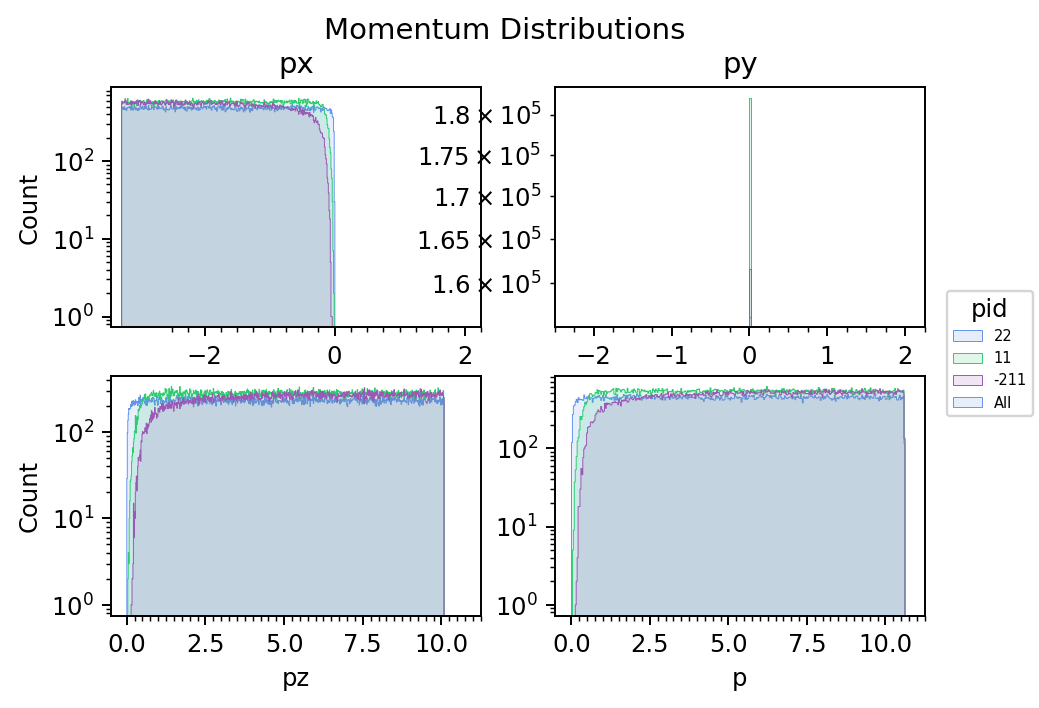

CPU times: user 2.63 s, sys: 426 ms, total: 3.05 s
Wall time: 2.76 s


In [7]:
%%time
all_sim = sim_df
columns = ["px","py","pz","p"]
widths = [0.01, 0.0150, 0.015, 0.03]
xlims = [[-2.5,2.5],[-2.5,2.5],[0,11.5],[0,11.5]]
locs = ["upper left","upper left","upper right"]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle(f"Momentum Distributions")

keeps = all_sim["Npesum"]>-20

for i in range(4):
    axes[int(i/2),i%2].set_title(f"{columns[i]}")
    sns.histplot(all_sim[keeps], x=columns[i], binwidth=widths[i], hue="pid", element="step", weights="rate",
                 linewidth=.4, palette=sns.color_palette(best_colors[:-1]), alpha=0.15, ax=axes[int(i/2),i%2], legend=0)
    
    axes[int(i/2),i%2].set_yscale("log")
    axes[int(i/2),i%2].set_xticks(np.arange(xlims[i][0],xlims[i][1],.25), minor=1)
    
fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})

#axes[0,0].set_xlim(-0.2,1.05)
#axes[0,1].set_xlim(-0.3,.3)

#Formatting
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[1,0].set_xlabel(f"{columns[2]}")
axes[1,1].set_xlabel(f"{columns[3]}")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[1,0].set_title("")
axes[1,1].set_title("")

#plt.savefig("SpecificPlots/Sim_Plots/Deg18_Sim_Momentum_Dist_raw.pdf")
#plt.savefig("Plots/NewCher_AngleCut_Momentum_Dist.pdf")
plt.show()
    

## PE Peaks
### NPE vs p

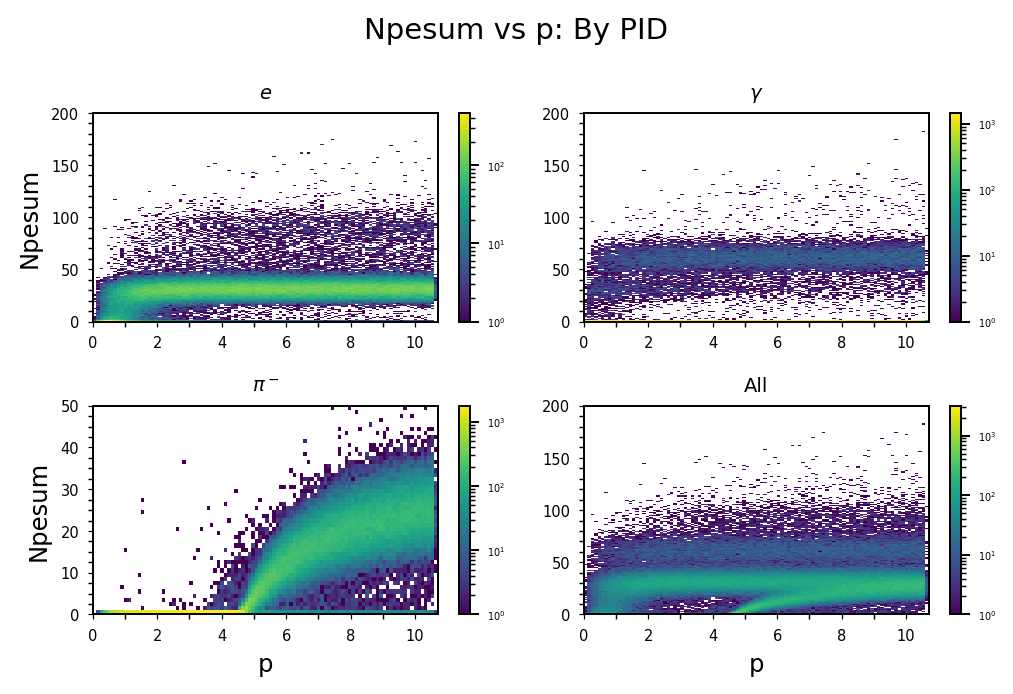

In [5]:
# Loop Over Shower Vals
columns =["p","Npesum"]
limits = [[(0,1500),(0,250)],[(0,250),(0,100)],[(0,150),(0,100)],[(0,250),(0,100)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100,170), (100,170), (100,70), (100,170)]
x_bin = [50, 5,5,5]


ylimits=[200,200,50,200]
y_ticks=[10,10,2.5,10]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Npesum vs p: By PID")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=((0,10.7),(0,ylimits[j])),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,ylimits[j]], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,11,1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/Pencil_NPE_p_Baseline.pdf")   #AngleCut


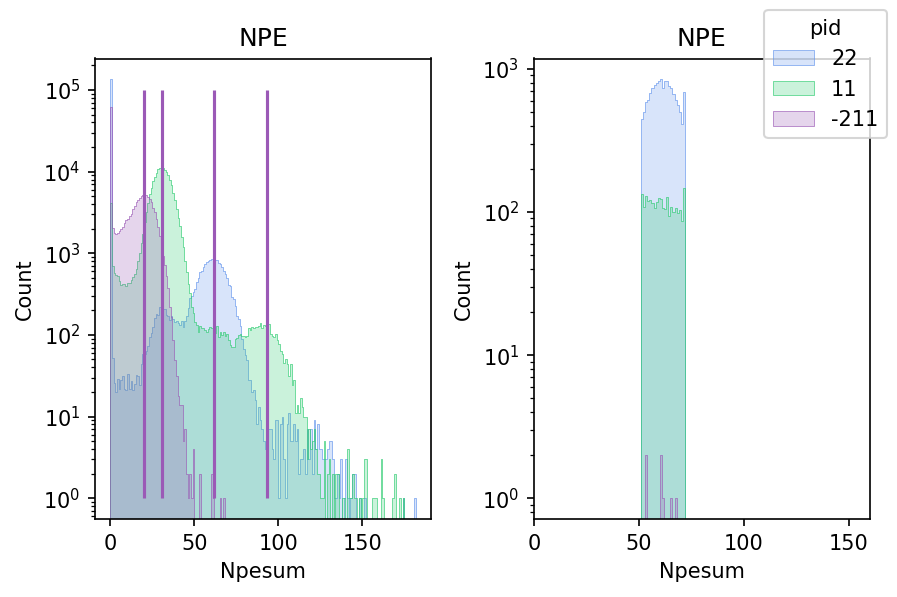

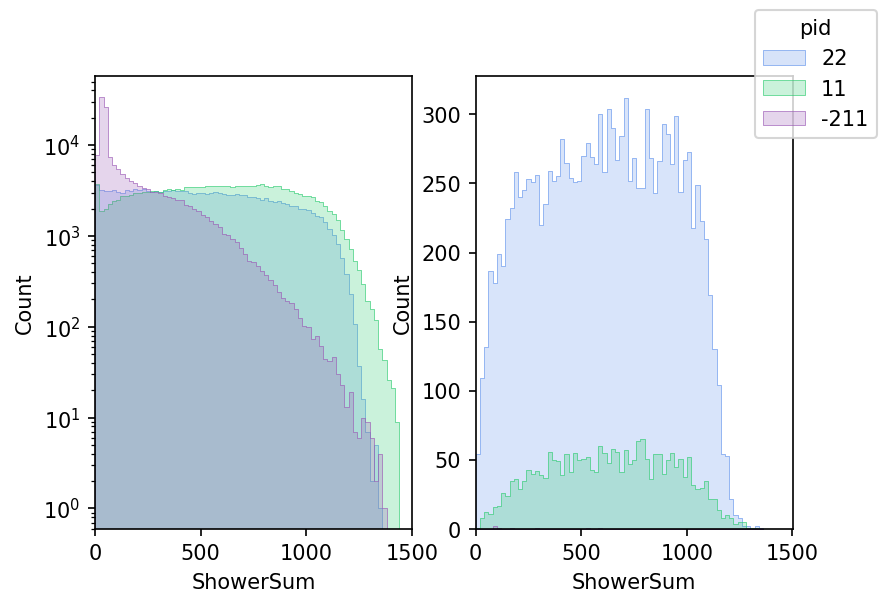

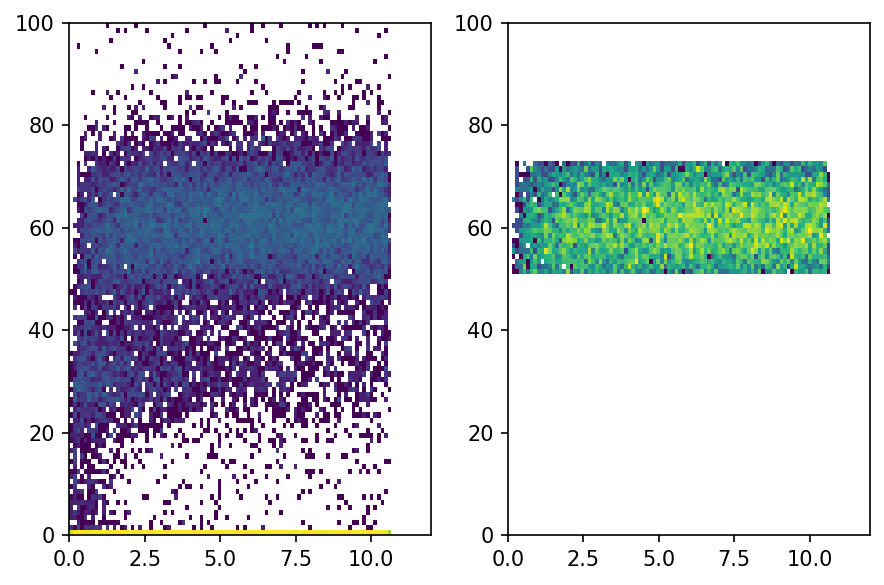

In [59]:
fig = plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.title("NPE")
plot_sim = sim_df[(sim_df["Npesum"]>50) & (sim_df["Npesum"]<73)]

sns.histplot(sim_df, x="Npesum", hue="pid", binwidth=1, element="step", legend=0,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.25, linewidth=0.3)
plt.yscale("log")
plt.vlines([20,31,62,93], 1,10**5)


plt.subplot(1,2,2)
plt.title("NPE")
plot_sim = sim_df[(sim_df["Npesum"]>50) & (sim_df["Npesum"]<73)]

sns.histplot(plot_sim, x="Npesum", hue="pid", binwidth=1, element="step", legend=0,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.25, linewidth=0.3)
plt.xlim(0,160)
plt.yscale("log")

#sns.histplot(bkg_Sim, x="Npesum", binwidth=1, element="step", 
#             color="red", alpha=0.05, linewidth=0.3)

#plt.vlines([20,31,62,93], 1,10**5)
#plt.yscale("log")
#plt.xlim(0,81)
#plt.xticks(np.arange(0,81,2.5), minor=1)

fig.legend(title='pid', labels=[22,11,-211], prop={"size":10})

plt.tight_layout()
#plt.savefig("Plots/Pencil_NPE.pdf")
plt.show()


fig = plt.figure(dpi=150)
plt.subplot(1,2,1)
sns.histplot(sim_df, x="ShowerSum",  hue="pid", binwidth=20, element="step", legend=0,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.25, linewidth=0.3)

plt.xlim(0,1501)
plt.yscale("log")

plt.subplot(1,2,2)
sns.histplot(plot_sim, x="ShowerSum",  hue="pid", binwidth=20, element="step", legend=0,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.25, linewidth=0.3)

plt.xlim(0,1501)
#plt.yscale("log")

fig.legend(title='pid', labels=[22,11,-211], prop={"size":10})





fig = plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.hist2d(sim_df[sim_df["pid"]==22]["p"], sim_df[sim_df["pid"]==22]["Npesum"], bins=[100,100], norm=LogNorm(), range=((0,12),(0,100)))


plt.subplot(1,2,2)
plt.hist2d(plot_sim[plot_sim["pid"]==22]["p"], plot_sim[plot_sim["pid"]==22]["Npesum"], bins=[100,100], norm=LogNorm(), range=((0,12),(0,100)))
plt.tight_layout()
plt.show()




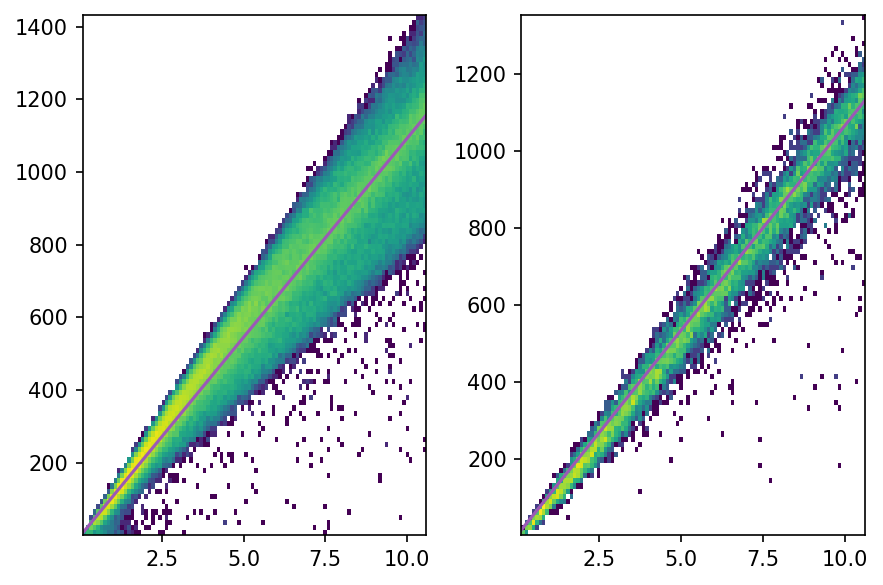

In [58]:
fig = plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.hist2d(sim_df[(sim_df["pid"]==11) & ((sim_df["Npesum"]>10) & (sim_df["Npesum"]<50))]["p"], 
           sim_df[(sim_df["pid"]==11) & ((sim_df["Npesum"]>10) & (sim_df["Npesum"]<50))]["ShowerSum"], 
           bins=[100,100], norm=LogNorm())#, range=((0,12),(0,2000)))

plt.plot([0,11],[0,1200])


plt.subplot(1,2,2)
plot_sim = sim_df[(sim_df["Npesum"]>50) & (sim_df["Npesum"]<73)]
plt.hist2d(plot_sim[plot_sim["pid"]==22]["p"], plot_sim[plot_sim["pid"]==22]["ShowerSum"], 
           bins=[100,100], norm=LogNorm())#, range=((0,12),(0,2000)))
plt.plot([0,11],[0,1175])

plt.tight_layout()
plt.show()

## Showers

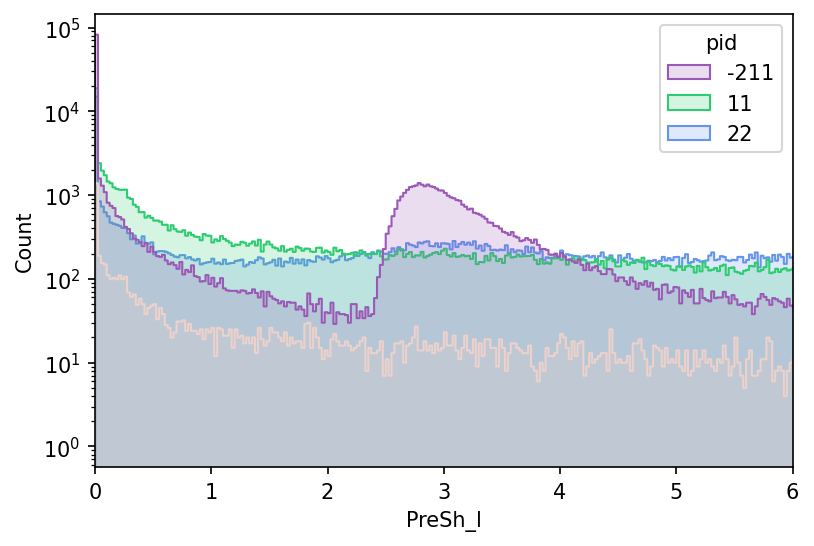

In [29]:
plot_sim = sim_df#[((sim_df["PreSh_l"]/sim_df["PreShSum"])>.95)] #[(sim_df["Npesum"]==0)

plt.figure(dpi=150)
sns.histplot(plot_sim, x=plot_sim["PreSh_l"], hue="pid", #weights="rate", 
             palette=sns.color_palette(best_colors[:-1]), 
             binwidth=.025, alpha=0.2, element="step")

sns.histplot(bkg_Sim, x=plot_sim["PreSh_l"], hue="pid", #weights="rate", 
             color=best_colors[0], legend=0,
             binwidth=.025, alpha=0.2, element="step")

plt.xlim(0,6)
#plt.ylim(0,200)
plt.yscale("log")
plt.show()

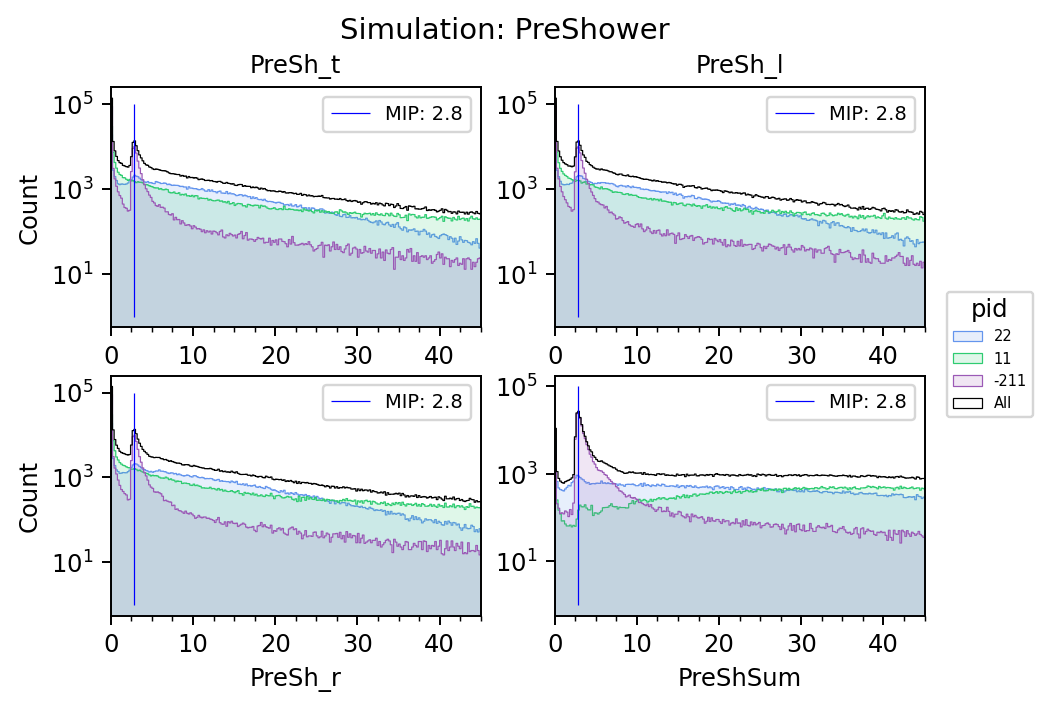

In [68]:
#
sim_MIPs = [2.8, 2.8, 2.8, 2.8]

fig, axes = plt.subplots(2, 2, dpi=175)

plot_sim = sim_df#[(sim_df["ShowerSum"]>0) & ((np.abs(sim_df["theta"]-81) < 2))]
bin_len = 0.2


#By Particle
sns.histplot(plot_sim, x= "PreSh_t",  hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]),
             #weights = "rate",
             alpha=0.15, ax= axes[0,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_l",  hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]), 
             #weights = "rate",
             alpha=0.15, ax= axes[0,1], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_r",  hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]), 
             #weights = "rate",
             alpha=0.15, ax= axes[1,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreShSum", hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]), 
             #weights = "rate",
             alpha=0.15, ax= axes[1,1], linewidth=0.5, legend=0)

#All
sns.histplot(plot_sim, x= "PreSh_t",  binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[0,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_l",  binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[0,1], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_r",  binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[1,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreShSum", binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[1,1], linewidth=0.5, legend=0)


fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})

#Log Scale
axes[0,0].set_yscale("log")
axes[0,1].set_yscale("log")
axes[1,0].set_yscale("log")
axes[1,1].set_yscale("log")

#Vlines
axes[0,0].vlines(sim_MIPs[0], 1, 10**5, label=f"MIP: {sim_MIPs[0]}", linewidths=.5, color="blue")
axes[0,1].vlines(sim_MIPs[1], 1, 10**5, label=f"MIP: {sim_MIPs[1]}", linewidths=.5, color="blue")
axes[1,0].vlines(sim_MIPs[2], 1, 10**5, label=f"MIP: {sim_MIPs[2]}", linewidths=.5, color="blue")
axes[1,1].vlines(sim_MIPs[3], 1, 10**5, label=f"MIP: {sim_MIPs[3]}", linewidths=.5, color="blue")

#Show Labels
axes[0,0].legend(prop={"size":8})
axes[0,1].legend(prop={"size":8})
axes[1,0].legend(prop={"size":8})
axes[1,1].legend(prop={"size":8})

#Titles
fig.suptitle(f"Simulation: PreShower")
axes[0,0].set_title(f"PreSh_t", fontsize=10)
axes[0,1].set_title(f"PreSh_l", fontsize=10)
axes[1,0].set_xlabel(f"PreSh_r", fontsize=10)
axes[1,1].set_xlabel(f"PreShSum", fontsize=10)  

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
#axes[1,0].set_xlabel("")
#axes[1,1].set_xlabel("")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

#Ticks
axes[0,0].set_xticks(np.arange(0,51,10))
axes[0,1].set_xticks(np.arange(0,51,10))
axes[1,0].set_xticks(np.arange(0,51,10))
axes[1,1].set_xticks(np.arange(0,51,10))

#Ticks
axes[0,0].set_xticks(np.arange(0,51,2.5), minor=1)
axes[0,1].set_xticks(np.arange(0,51,2.5), minor=1)
axes[1,0].set_xticks(np.arange(0,51,2.5), minor=1)
axes[1,1].set_xticks(np.arange(0,51,2.5), minor=1)

#Limits
axes[0,0].set_xlim(0,45)
axes[0,1].set_xlim(0,45)
axes[1,0].set_xlim(0,45)
axes[1,1].set_xlim(0,45)

#plt.tight_layout()
plt.savefig("Plots/NewCher_PreShower_AngleCut.pdf")
plt.show()

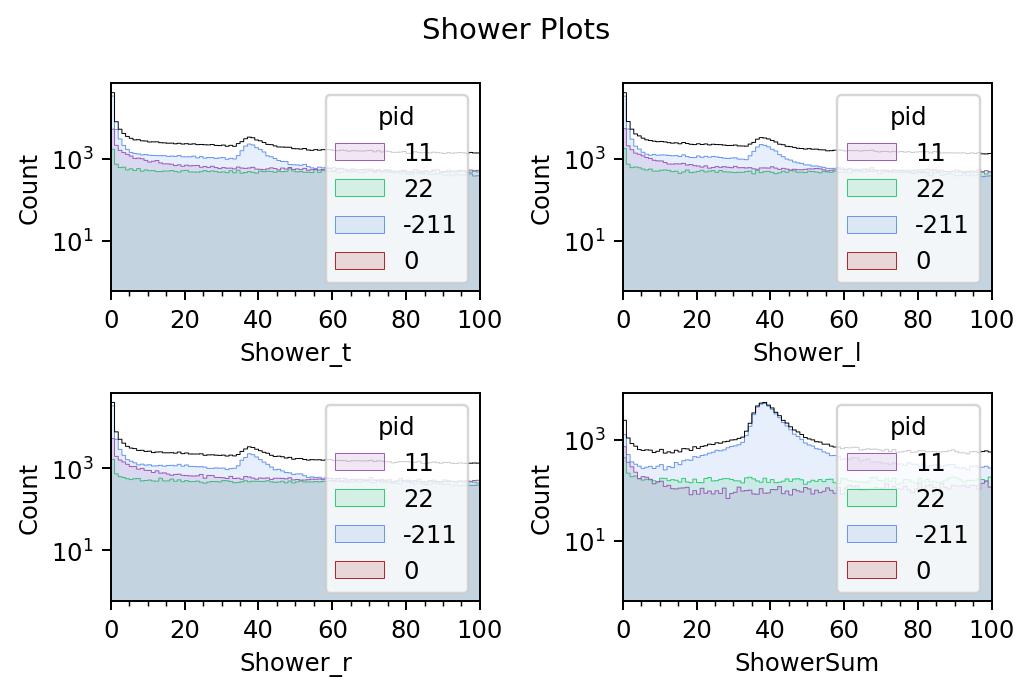

In [71]:
#Variables to plot
plot_vars = ["Shower_t", "Shower_l", "Shower_r", "ShowerSum"]

fig = plt.figure(dpi=175)
plt.suptitle("Shower Plots")

for i in range(4):
    plot_sim = sim_df#.append(bkg_Sim)
    width = 1
    
    plt.subplot(2,2,1+i)
    sns.histplot(plot_sim, x=plot_vars[i],  hue="pid", hue_order=[11,22,-211,0],
                 binwidth=width, element="step", palette=sns.color_palette(best_colors), 
                 alpha=0.15, linewidth=0.4, legend=1,
                # weights="rate"
                )
    sns.histplot(plot_sim, x=plot_vars[i],  binwidth=width, element="step", color="black", 
                 alpha=0, linewidth=0.4, legend=1,
                #weights="rate"
                )
    
    #Subplot Formatting
    #plt.vlines(37.5, 1, 10**4, label=f"MIP: {37.5}", linewidths=.5, color="blue")
    #plt.legend(fontsize=8)
    #plt.setp(ax.get_legend().get_title(), fontsize='6')
    #plt.setp(ax.get_legend().get_texts(), fontsize='5')
    
    plt.xticks(np.arange(0,100+1,5), minor=1)
    plt.xlim(0,100)
    
    plt.yscale("log")
    #plt.yticks(10.**np.arange(-3,6,1), minor=1, fontsize=0, alpha=0)

    
plt.tight_layout()
#fig.legend(title='pid', loc=7, labels=[11,22,-211,"All"], prop={"size":6})

plt.savefig("Plots/NewCher_Shower_AngleCut.pdf")


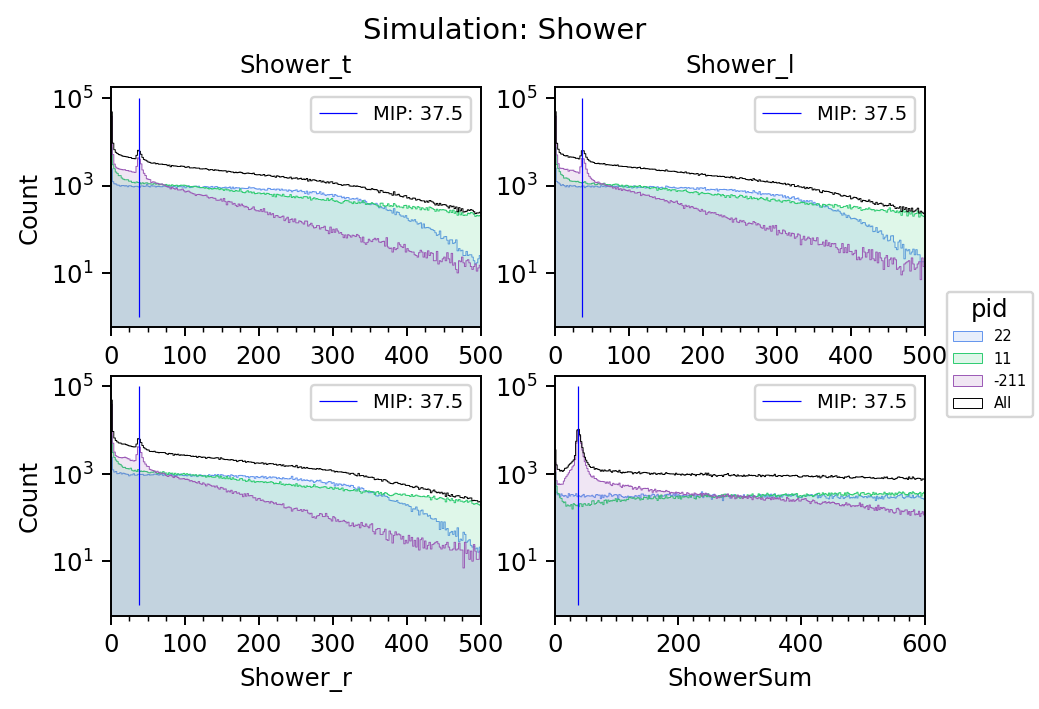

In [21]:
#
sim_MIPs = [3.2, 3.25, 3.25, 3.25, 10, 10, 10, 10, 9.2, 9.2, 1.0, 3.5, .5, 0, 0]

fig, axes = plt.subplots(2, 2, dpi=175)

plot_sim = sim_df#new_raw_sim_df[(new_raw_sim_df["ShowerSum"]>0) & ((np.abs(new_raw_sim_df["theta"]-81) < 2))]

width=2
#By Particle
sns.histplot(plot_sim, x= "Shower_t",  hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[0,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_l",  hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[0,1], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_r",  hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[1,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "ShowerSum", hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[1,1], linewidth=0.4, legend=0)

#All
sns.histplot(plot_sim, x= "Shower_t",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_l",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,1], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_r",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "ShowerSum", binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,1], linewidth=0.4, legend=0)

sns.histplot(plot_sim, x= "Shower_t",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_l",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,1], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_r",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "ShowerSum", binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,1], linewidth=0.4, legend=0)


fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})

#Vlines
axes[0,0].vlines(37.5, 1, 10**5, label=f"MIP: {37.5}", linewidths=.5, color="blue")
axes[0,1].vlines(37.5, 1, 10**5, label=f"MIP: {37.5}", linewidths=.5, color="blue")
axes[1,0].vlines(37.5, 1, 10**5, label=f"MIP: {37.5}", linewidths=.5, color="blue")
axes[1,1].vlines(37.5, 1, 10**5, label=f"MIP: {37.5}", linewidths=.5, color="blue")

#Legends
axes[0,0].legend(prop={"size":8})
axes[0,1].legend(prop={"size":8})
axes[1,0].legend(prop={"size":8})
axes[1,1].legend(prop={"size":8})

#Log Scale
axes[0,0].set_yscale("log")
axes[0,1].set_yscale("log")
axes[1,0].set_yscale("log")
axes[1,1].set_yscale("log")

#Titles
fig.suptitle(f"Simulation: Shower")
axes[0,0].set_title(f"Shower_t", fontsize=10)
axes[0,1].set_title(f"Shower_l", fontsize=10)
axes[1,0].set_xlabel(f"Shower_r", fontsize=10)
axes[1,1].set_xlabel(f"ShowerSum", fontsize=10)  

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
#axes[1,0].set_xlabel("")
#axes[1,1].set_xlabel("")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

#Ticks
axes[0,0].set_xticks(np.arange(0,500+1,25), minor=1)
axes[0,1].set_xticks(np.arange(0,500+1,25), minor=1)
axes[1,0].set_xticks(np.arange(0,500+1,25), minor=1)
axes[1,1].set_xticks(np.arange(0,600+1,25), minor=1)

#Limits
axes[0,0].set_xlim(0,500)
axes[0,1].set_xlim(0,500)
axes[1,0].set_xlim(0,500)
axes[1,1].set_xlim(0,600)

#plt.tight_layout()
plt.savefig("Plots/NewCher_Shower_AngleCut.pdf")
plt.show()

In [18]:
0.5*194

97.0

## PreSh vs Shower

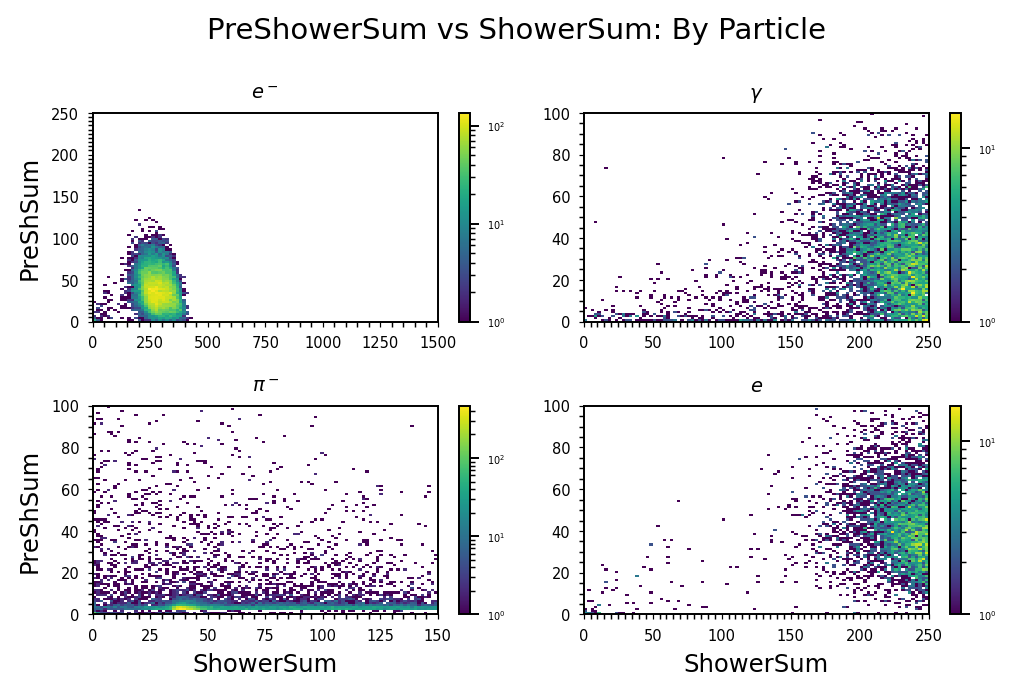

In [10]:
# Loop Over Shower Vals
columns =["ShowerSum","PreShSum"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,1500),(0,250)],[(0,250),(0,100)],[(0,150),(0,100)],[(0,250),(0,100)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 5,5,5]

#line_ests = [[[0,100],[100,0]],[[0,120],[130,0]],[[0,130],[120,0]],[[0,130],[120,0]]]

all_sim = sim_df

pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e^-$", "$\gamma$", "$\pi^-$", "$e$"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("PreShowerSum vs ShowerSum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    plot_sim = all_sim[(all_sim["pid"]==part_ids[j]) & (all_sim["p"]>2) &(all_sim["p"]<3)]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=bins[j], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,limits[j][0][1],x_bin[j]), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,limits[j][1][1],5), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_PreShSum_ShowerSum.pdf")   #AngleCut


## LASPD

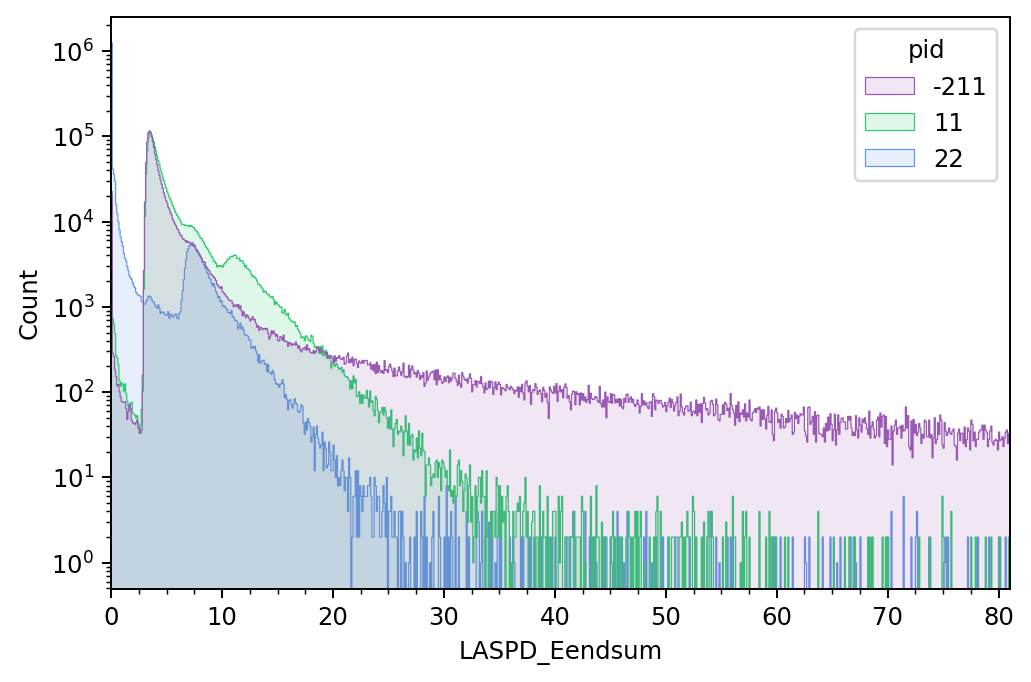

In [13]:
plt.figure(dpi=175)
#plot_sim = sim_df[sim_df["Npesum"]>0]

sns.histplot(sim_df, x="LASPD_Eendsum", hue="pid", binwidth=.1, element="step", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
plt.xlim(0,81)
plt.xticks(np.arange(0,81,2.5), minor=1)

plt.tight_layout()
plt.savefig("Plots/NewCher_LASPD.pdf")
plt.show()

## Scintillator

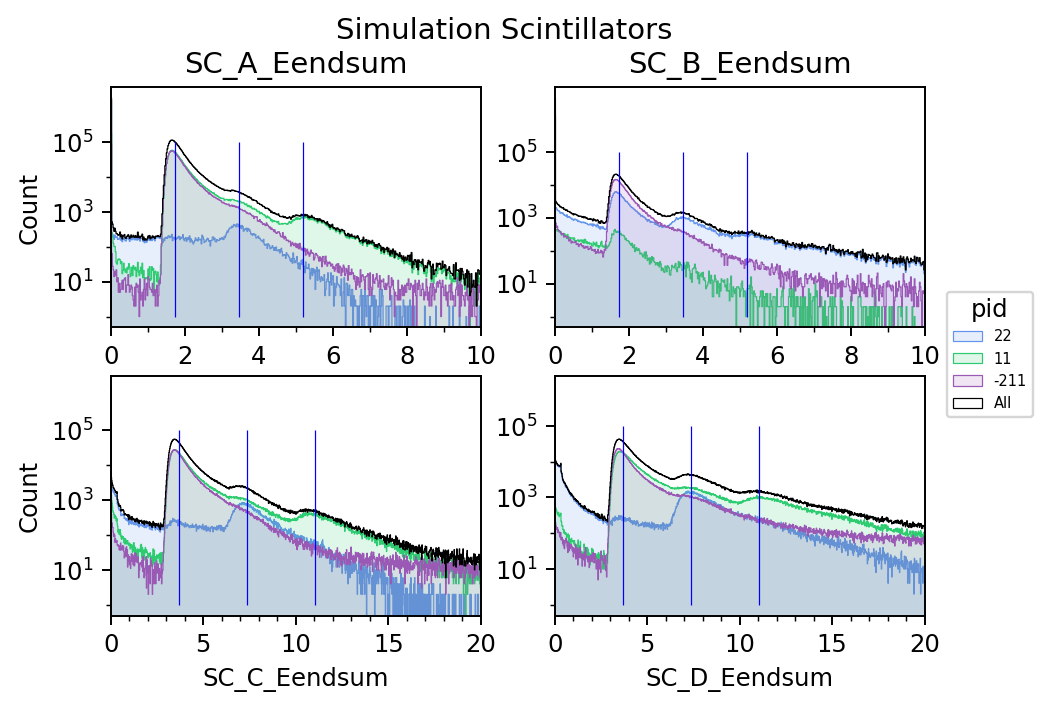

In [14]:
#
sim_MIPs = [1.65, 1.65, 3.5, 3.5]

plot_sim = all_sim#[sim_df["Npesum"]>0]#(np.array(sim_df["SC_A_Eendsum"]>0, dtype=int) + np.array(sim_df["SC_B_Eendsum"]>0, dtype=int) 
                   #+ np.array(sim_df["SC_C_Eendsum"]>0, dtype=int) + np.array(sim_df["SC_D_Eendsum"]>0, dtype=int)) >= 2]

plot_cols = ["SC_A_Eendsum","SC_B_Eendsum","SC_C_Eendsum","SC_D_Eendsum"]

limits = [10,10,20,20]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Simulation Scintillators")

for i in range(4):
    

    sns.histplot(plot_sim, x= plot_cols[i],  hue="pid", binwidth=0.02, element="step", palette=sns.color_palette(best_colors[:-1]), 
                 weights="rate",
                  alpha=0.15, linewidth=0.5, ax=axes[int(i/2),i%2], legend=0)
    
    sns.histplot(plot_sim, x=plot_cols[i],  binwidth=0.02, element="step", color="black", 
                 weights="rate",
                  alpha=0, linewidth=0.5, ax=axes[int(i/2),i%2], legend=0)
    
    axes[int(i/2),i%2].vlines(np.array([1,2,3])*(sim_MIPs[i]*1.05), 1, 10**5, label=f"MIP: {sim_MIPs[i]}", linewidths=.5, color="blue")
    
    #plt.legend()

    axes[int(i/2),i%2].set_yscale("log")
    axes[int(i/2),i%2].set_yticks(10**np.arange(0,6,1),minor=1)
    
    axes[int(i/2),i%2].set_xlim(0,limits[i])
    axes[int(i/2),i%2].set_xticks(np.arange(0,limits[i],1), minor=1)
    
    #axes[int(i/2),i%2].set_xlabel("")
    axes[int(i/2),i%2].set_ylabel("")
    
    #Axis Labels
    if i in [0,2]:
        axes[int(i/2),i%2].set_ylabel(f"Count") 
    
    if i in [0,1]:
        axes[int(i/2),i%2].set_title(f"{plot_cols[i]}")  
        

    axes[int(i/2),i%2].tick_params(axis="y", which="minor", labelsize=0, labelcolor="white")
        
fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})
#plt.tight_layout()   
#plt.savefig(f"Plots/NewCher_SimScintillator.pdf")
    
#plt.show()

## GEM

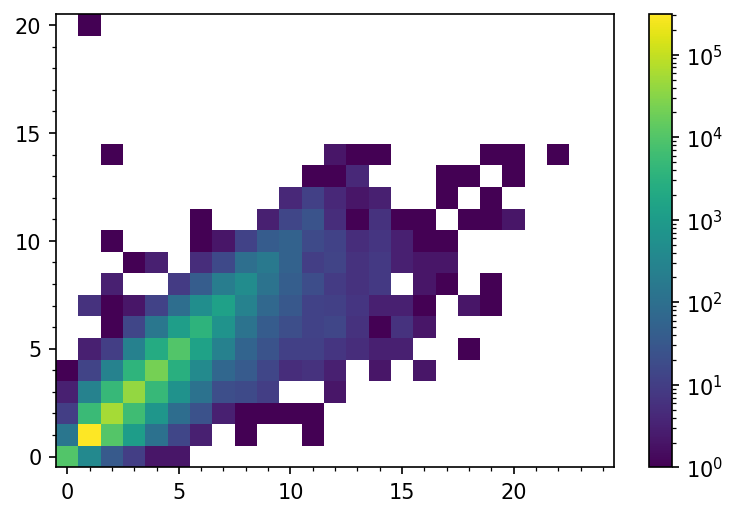

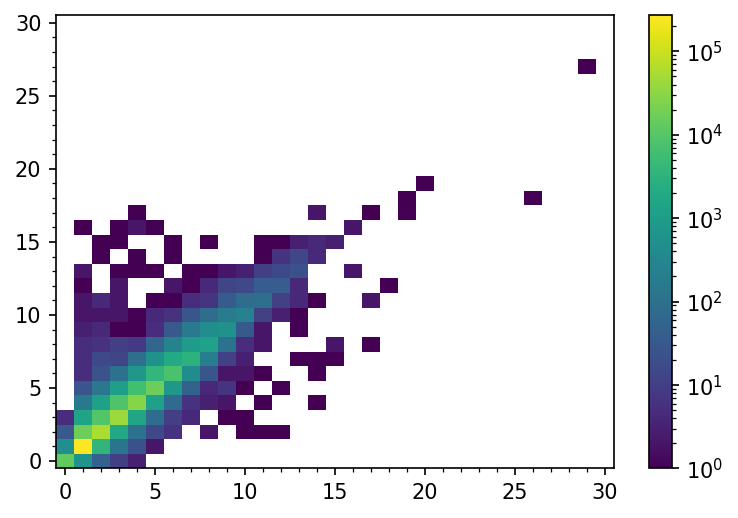

In [12]:
plt.figure(dpi=150)

plt.hist2d(sim_df["GEM00_n"], sim_df["GEM01_n"], norm=LogNorm(), bins=[np.arange(-1,25,1)+0.5,np.arange(-1,21,1)+0.5]
           #range=((0,13),(0,10))
          )

plt.xticks(np.arange(0,25,1), minor=1)
plt.yticks(np.arange(0,21,5))
plt.yticks(np.arange(0,21,1), minor=1)

plt.colorbar()
plt.show()

plt.figure(dpi=150)

plt.hist2d(sim_df["GEM10_n"], sim_df["GEM11_n"], norm=LogNorm(), bins=[np.arange(-1,31,1)+0.5,np.arange(-1,31,1)+0.5], 
           #range=((0,13),(0,10))
          )

plt.xticks(np.arange(0,31,1), minor=1)
plt.yticks(np.arange(0,31,1), minor=1)

plt.colorbar()
plt.show()

In [ ]:
%%time

GEM00_X = [np.mean(x) for x in sim_df["GEM00_vx"]]
GEM00_X

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


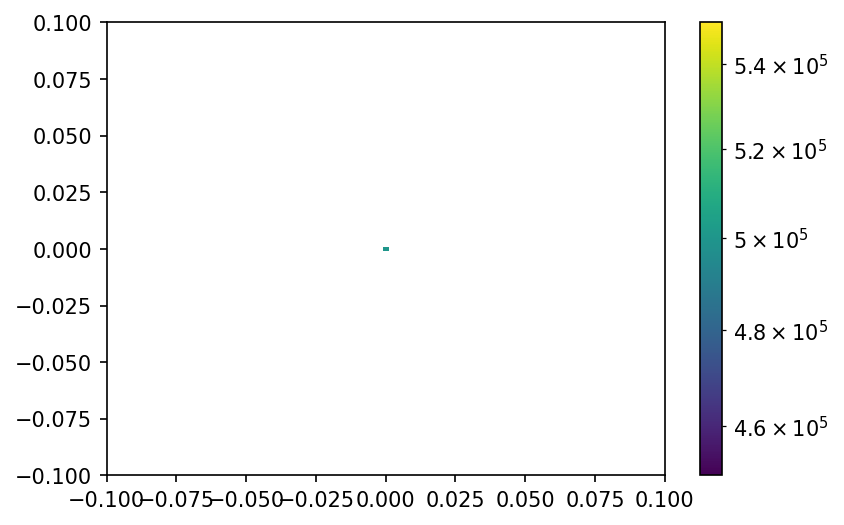

In [16]:
plt.figure(dpi=150)

plt.hist2d(sim_df["vx"], sim_df["vy"], norm=LogNorm(), bins=[np.linspace(-.1,.1,100),np.linspace(-.1,.1,100)]
           #range=((0,13),(0,10))
          )

"""plt.xticks(np.arange(0,25,1), minor=1)
plt.yticks(np.arange(0,21,5))
plt.yticks(np.arange(0,21,1), minor=1)"""

plt.colorbar()
plt.show()


In [14]:
sim_df.columns

Index(['rate', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'p', 'pid', 'PreShP',
       'PreShP_e', 'PreShPx', 'PreShPy', 'PreShPz', 'PreShtheta', 'PreShSum',
       'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l', 'Shower_r',
       'Shower_t', 'SC_A_P', 'SC_A_Eendsum', 'SC_A_Eend', 'SC_D_P',
       'SC_D_Eendsum', 'SC_D_Eend', 'SC_C_P', 'SC_C_Eendsum', 'SC_C_Eend',
       'SC_B_P', 'SC_B_Eendsum', 'SC_B_Eend', 'SPD_P', 'SPD_Eendsum',
       'SPD_Eend', 'LASPD_P', 'LASPD_Eendsum', 'LASPD_Eend', 'GEM00_n',
       'GEM00_np', 'GEM00_x', 'GEM00_y', 'GEM00_vy', 'GEM00_vx', 'GEM00_Edep',
       'GEM00_Edep2', 'GEM00_Edep3', 'GEM00_Etot', 'GEM10_n', 'GEM10_np',
       'GEM10_x', 'GEM10_y', 'GEM10_vy', 'GEM10_vx', 'GEM10_Edep',
       'GEM10_Edep2', 'GEM10_Edep3', 'GEM10_Etot', 'GEM01_n', 'GEM01_np',
       'GEM01_x', 'GEM01_y', 'GEM01_vy', 'GEM01_vx', 'GEM01_Edep',
       'GEM01_Edep2', 'GEM01_Edep3', 'GEM01_Etot', 'GEM11_n', 'GEM11_np',
       'GEM11_x', 'GEM11_y', 'GEM11_vy', 'GEM11_vx',

In [13]:
sim_df["GEM00_x"]

1271445                                [0.12066655606031418]
1291198           [-0.5998276472091675, -0.4670591652393341]
3040514                            [-1.1215219274163246e-05]
1664542          [0.02737444080412388, -0.03783119469881058]
718312     [0.2051692008972168, 0.2063513845205307, 0.986...
                                 ...                        
4035089                                  [3.278167486190796]
1954273                            [-1.1215219274163246e-05]
3810076                                [-0.5392010807991028]
3270677                            [-1.1215219274163246e-05]
2857708                            [-1.1215219274163246e-05]
Name: GEM00_x, Length: 500000, dtype: object

## Cherenkov

In [28]:
np.array(np.array(sim_df["Cer"]).sum())#.sum()

array([  55192.,  274829.,  275400.,   55671.,  273513., 1493666.,
       1497937.,  277213.,  275531., 1505948., 1506716.,  277241.,
         57669.,  275979.,  276876.,   57702.], dtype=float32)

In [16]:
sim_df["Npesum"].sum()

8437083.0

In [32]:
np.array(sim_df["Cer"])#.shape()

array([<cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x55629e15a300>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x55629e15a3c0>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x55629e15a480>, ...,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x5562a3d110d0>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x5562a3d11190>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x5562a3d11250>],
      dtype=object)

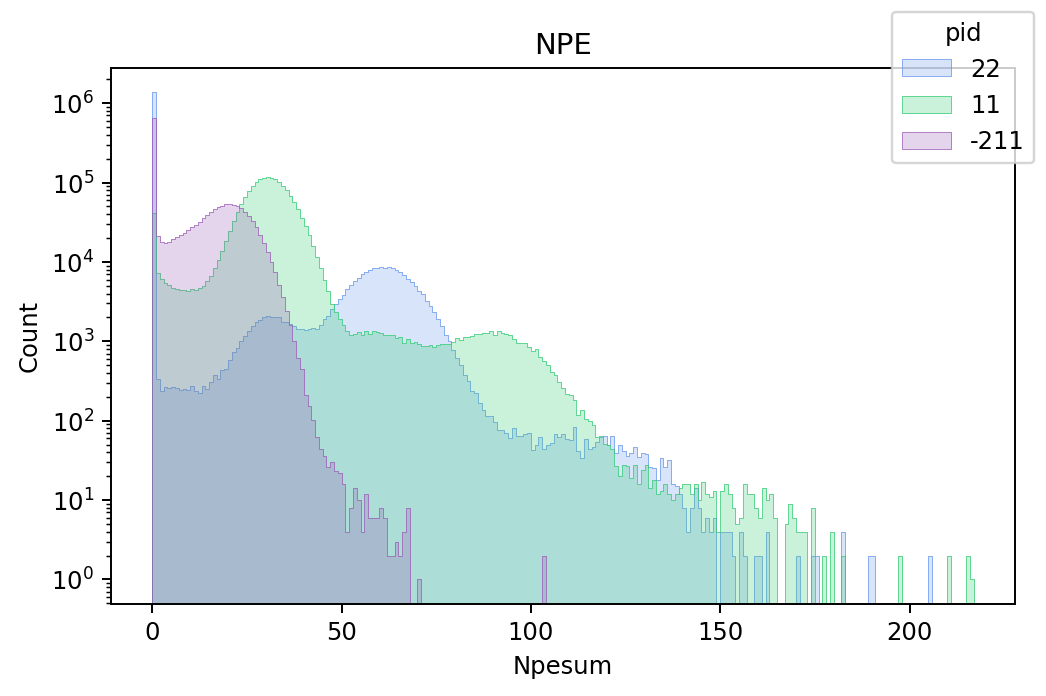

In [10]:
fig = plt.figure(dpi=175)
plt.title("NPE")
#plot_sim = sim_df[sim_df["Npesum"]>0]

sns.histplot(all_sim, x="Npesum", hue="pid", binwidth=1, element="step", legend=0,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.25, linewidth=0.3)

#sns.histplot(bkg_Sim, x="Npesum", binwidth=1, element="step", 
#             color="red", alpha=0.05, linewidth=0.3)

#plt.vlines([20,31,62,93], 1,10**5)
plt.yscale("log")
#plt.xlim(0,81)
#plt.xticks(np.arange(0,81,2.5), minor=1)

fig.legend(title='pid', labels=[22,11,-211,"Bkg"], prop={"size":10})

plt.tight_layout()
plt.savefig("Plots/Pencil_NPE.pdf")
plt.show()

In [23]:
%%time

channel_list = [[] for _ in range(16)]
    
for row in all_sim["Cer"]:#[data0["TrigType"] == 32]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T

CPU times: user 3.4 s, sys: 267 ms, total: 3.67 s
Wall time: 3.66 s


### Channel Dists

In [24]:
len(Cer_array[:,0])

500000

CPU times: user 7.64 s, sys: 1.43 s, total: 9.07 s
Wall time: 8.29 s


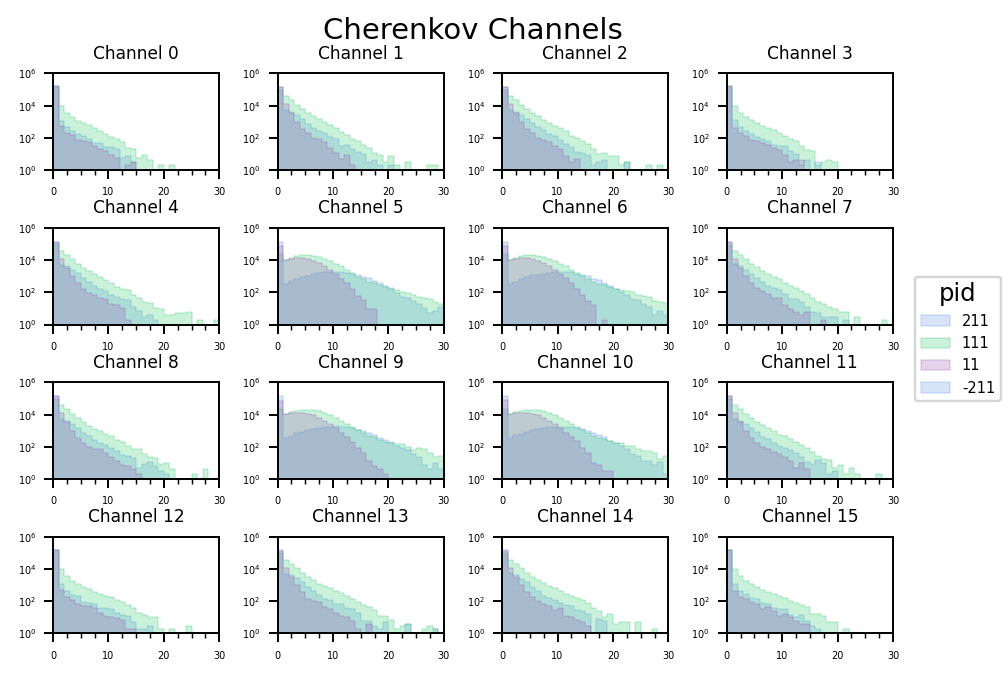

In [25]:
%%time

channel_order = [15,14,11,10,13,12,9,8,7,6,3,2,5,4,1,0]
#Make Plot

fig, axes = plt.subplots(4, 4, dpi=175)
keeps = (all_sim["Npesum"] > -1)

plot_data = all_sim
range_factor = 10

#By L, R, T, Sum
for j in range(4):
    for k in range(4):
        #Get Channel Num
        channel_num = j*4+k#channel_order[j*4+k]
               
        #Get Data
        axes[j,k].set_title(f"Channel {channel_num}", fontsize=7)
        loop_data = Cer_array[:,[channel_num]]
        
        sns.histplot(plot_data[keeps], x=(loop_data.flatten())[keeps], hue="pid", binwidth=1, 
                     element="step", linewidth=.15, palette=sns.color_palette(best_colors[:-1]), 
                     alpha=0.25, ax=axes[j,k], legend=0)
        #Axis Formatting
        axes[j,k].set_xlim(0,30)
        axes[j,k].set_xticks(np.arange(0,30,2.5), minor=1)
        axes[j,k].set_ylim(1, 10**5+1)
        axes[j,k].set_yticks(10**np.arange(0,7), minor=1)

        #Formatting                            
        axes[j,k].set_yscale("log")
        axes[j,k].set_xlabel("")
        axes[j,k].set_ylabel("")
        axes[j,k].tick_params(axis="both", which="major", labelsize=4)
        axes[j,k].tick_params(axis="both", which="minor", labelsize=1)


#Figure Formatting
fig.suptitle(f"Cherenkov Channels")
fig.legend(title='pid', loc=7, labels=[211,111,11,-211], prop={"size":6})

#Output Formatting
#plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.35, hspace=0.6)
plt.savefig(f"Plots/NewCher_CherenkovChannels.pdf")
#plt.show()

### N_Ch vs NPE

CPU times: user 2.28 s, sys: 1.06 s, total: 3.34 s
Wall time: 1.94 s


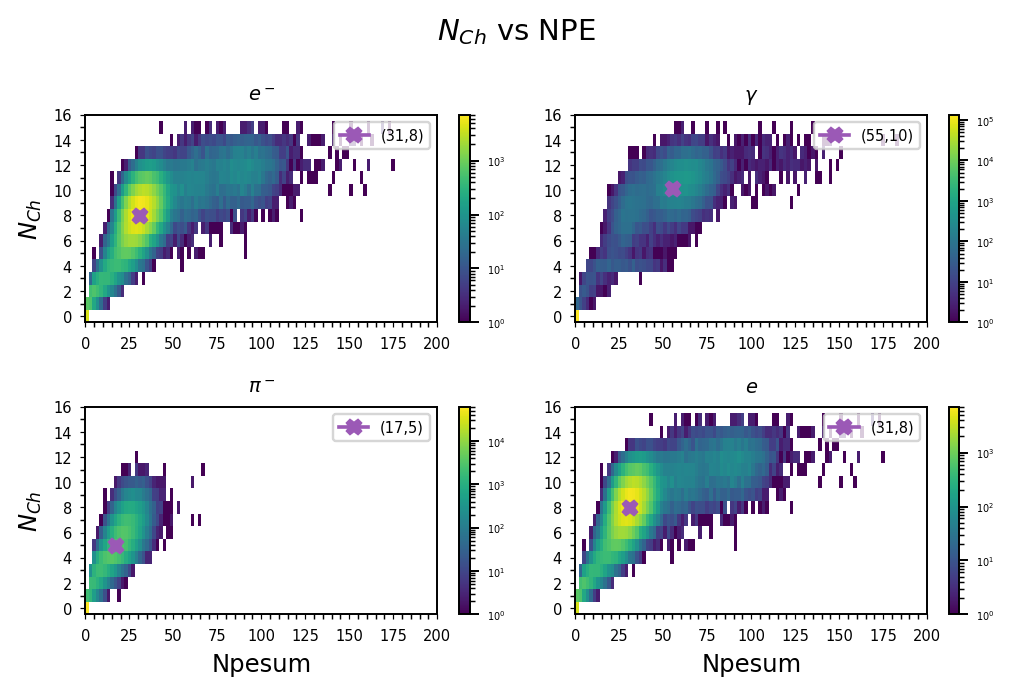

In [26]:
%%time 

# Loop Over Shower Vals
columns =["Npesum","$N_{Ch}$"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,600),(0,150)],[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,100)]]
bins = [[60,15], [30,8], [60,12], [30,8]]


particles = ["$e^-$", "$\gamma$", "$\pi^-$", "$e$"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("$N_{Ch}$ vs NPE")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8)
    
    keeps = (all_sim["pid"]==part_ids[j])

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(all_sim["Npesum"][keeps], (Cer_array>0).sum(axis=1)[keeps],
                                                         #weights="rate",
                                                         #bins=[np.arange(0,bins[j][0],1),np.arange(0.5,bins[j][1]+.5,1)], 
                                                         bins=[np.arange(0,201,2),np.arange(-0.5,16.5,1)], norm=LogNorm())
    #Blob centers
    mu_NPE = np.mean(all_sim["Npesum"][(keeps) & (all_sim["Npesum"]>0)])
    mu_NCh = np.mean((Cer_array>0).sum(axis=1)[(keeps) & (all_sim["Npesum"]>0)])
    axes[int(j/2),j%2].plot(mu_NPE, mu_NCh, marker="X", label=f"({mu_NPE:.0f},{mu_NCh:.0f})")
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    axes[int(j/2),j%2].legend(fontsize=6)
    
    #Scaling Line
    x = np.arange(0,60,1)
    #axes[int(j/2),j%2].plot(x,x)
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,5),minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,16.1,2))
    axes[int(j/2),j%2].set_yticks(np.arange(0,16.1,1),minor=1)
    #axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/NewCher_NCh_NPE.pdf") 


### Heatmap

In [31]:
sim_df["Cer"]#[0]

1271445    [0.0, 1.0, 5.0, 0.0, 1.0, 10.0, 5.0, 1.0, 0.0,...
1291198    [0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 6.0, 0.0, 2.0, ...
3040514    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1664542    [0.0, 1.0, 0.0, 0.0, 1.0, 6.0, 5.0, 0.0, 0.0, ...
718312     [0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 7.0, 0.0, 2.0, ...
                                 ...                        
4035089    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1954273    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3810076    [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...
3270677    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2857708    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Cer, Length: 500000, dtype: object

In [32]:
Cer_array

array([[0., 1., 5., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

keeps = (all_sim["pid"]==11)&(sim_df["Shower_t"]>500)&(sim_df["Shower_l"]>500) 
channel_sums = (Cer_array[keeps]).sum(axis=0)*np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

np.rot90(channel_sums.reshape(4,4).astype(int))

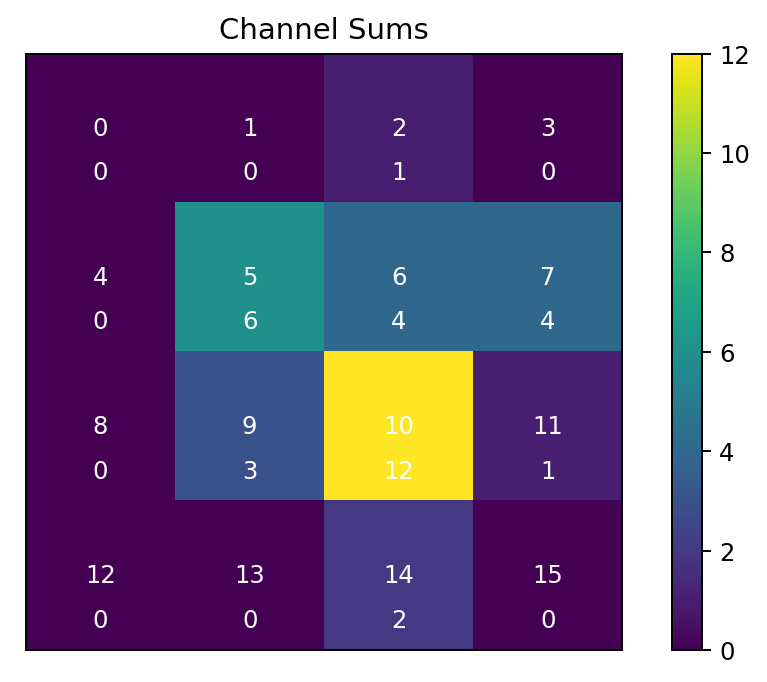

In [150]:
#Normalize Channels and Get Sums
keeps = (all_sim["pid"]==11)#&(sim_df["Shower_t"]>500)&(sim_df["Shower_l"]>600) #& (sim_df["Shower_t"]>500) #(all_sim["pid"]==11)&(all_sim["Npesum"]>0) #

channel_sums = (Cer_array[keeps])[1]#.sum(axis=0)*np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) #Cer_array[keeps][0]


#Labels
labels = [["D3","D2","C3","C2"],
          ["D1","D0","C1","C0"],
          ["B3","B2","A3","A2"],
          ["B1","B0","A1","A0"]]

order = np.arange(0,16,1) #[15,14,11,10,13,12,9,8,7,6,3,2,5,4,1,0]#

#Make Heatmap
fig, ax = plt.subplots(dpi=175)
plt.title("Channel Sums")
#plt.title("Normalized Sum Before Coincidence Cuts")
im = ax.imshow(np.rot90((channel_sums).reshape(4,4),k=1))#(((channel_sums).reshape((4, 4))).T)

ax.set_xticks([])
ax.set_yticks([])

for i in range(4):
    for j in range(4):
        text = ax.text(i, j, (np.arange(0,16,1).reshape((4, 4)).T)[i][j], ha="center", va="center", color="w") #labels[i][j]
        text = ax.text(i, j+.3, (np.rot90((channel_sums.reshape((4, 4)))).T).astype(int)[i][j], ha="center", va="center", color="w")

ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
plt.savefig(f"Plots/NewCher_ChannelHeatmap.pdf")
plt.show()


### Shower Center Cuts

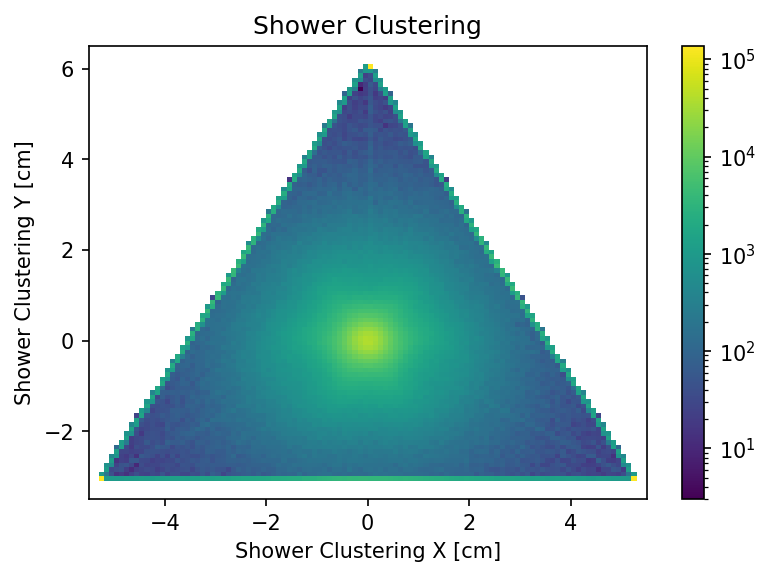

In [51]:
Clust_x, Clust_y, Clust_z = Shower_Clustering(all_sim["Shower_l"],all_sim["Shower_t"],all_sim["Shower_r"])

plt.figure(dpi=150)
plt.title("Shower Clustering")
plt.xlabel("Shower Clustering X [cm]")
plt.ylabel("Shower Clustering Y [cm]")

keeps = ((Clust_x**2 + Clust_y**2)**0.5 < 200)

plt.hist2d(Clust_x[keeps], Clust_y[keeps], norm=LogNorm(), #weights=all_sim["rate"],
           bins=[np.arange(-5.5,5.6,.1),np.arange(-3.5,6.6,.1)])#, range=((-5.5,5.5),(-3.5,6.5)))

plt.colorbar()

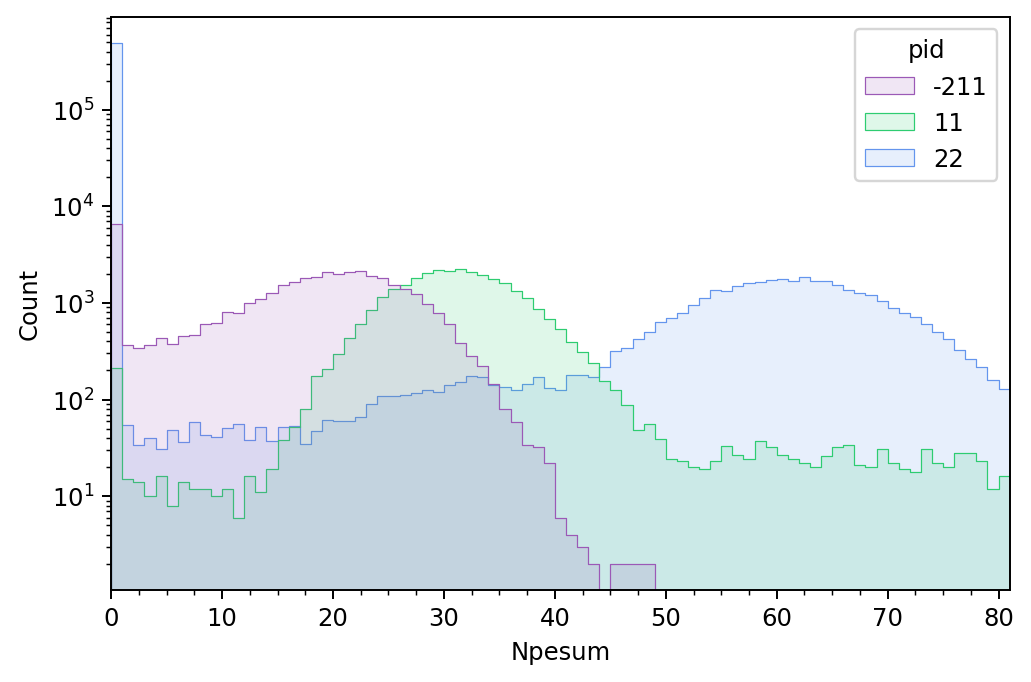

In [53]:
plt.figure(dpi=175)
#plot_sim = sim_df[sim_df["Npesum"]>0]

keeps = ((Clust_x**2 + Clust_y**2)**0.5 < .25)

sns.histplot(all_sim[keeps], x="Npesum", hue="pid", binwidth=1, element="step", #weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
plt.xlim(0,81)
plt.xticks(np.arange(0,81,2.5), minor=1)

plt.tight_layout()
plt.savefig("Plots/NewCher_NPE_CenterCut.pdf")
plt.show()

In [99]:
np.flip((np.arange(0,16)).reshape((4, 4)),axis=1).T

array([[ 3,  7, 11, 15],
       [ 2,  6, 10, 14],
       [ 1,  5,  9, 13],
       [ 0,  4,  8, 12]])

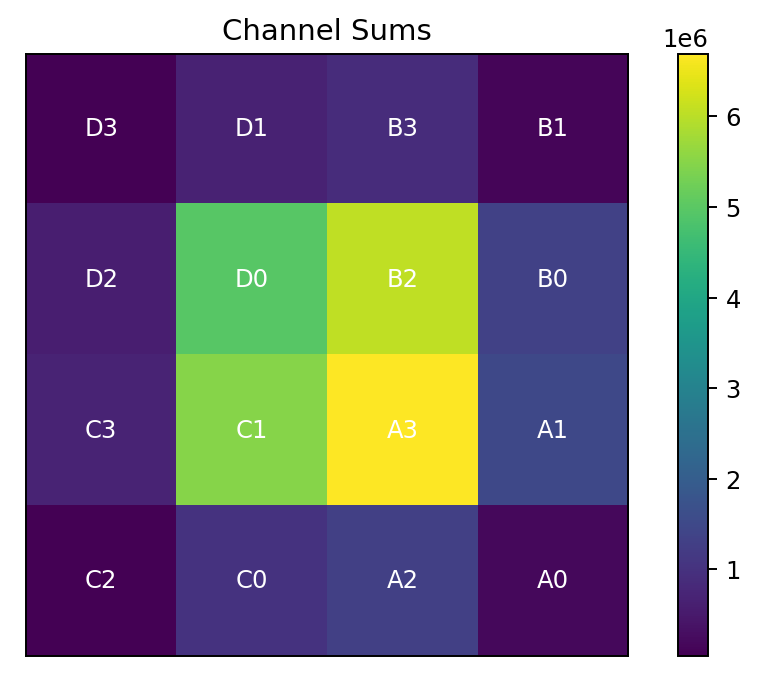

In [56]:
#Normalize Channels and Get Sums
keeps = (sim_df["Shower_r"]>20) & (sim_df["Shower_t"]>20) #(Clust_x>0) & (Clust_y<0)
#((Clust_x**2 + Clust_y**2)**0.5 < 1)#(sim_df["Shower_r"]>20) & (sim_df["Shower_t"]>20)

channel_sums = ((Cer_array)[keeps]).sum(axis=0)*np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])


#Labels
labels = [["D3","D2","C3","C2"],
          ["D1","D0","C1","C0"],
          ["B3","B2","A3","A2"],
          ["B1","B0","A1","A0"]]

order = np.arange(0,16,1)#[15,14,11,10,13,12,9,8,7,6,3,2,5,4,1,0]

#Make Heatmap
fig, ax = plt.subplots(dpi=175)
plt.title("Channel Sums")
#plt.title("Normalized Sum Before Coincidence Cuts")
im = ax.imshow(np.flip((channel_sums).reshape((4, 4)),axis=1).T)

ax.set_xticks([])
ax.set_yticks([])

for i in range(4):
    for j in range(4):
        text = ax.text(i, j, labels[i][j], ha="center", va="center", color="w") #labels[i][j]
        #text = ax.text(i, j, np.arange(0,16,1)[order].reshape((4, 4))[i][j], ha="center", va="center", color="w")
        

ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
plt.savefig(f"Plots/NewCher_ChannelHeatmap_Cuts.pdf")
plt.show()


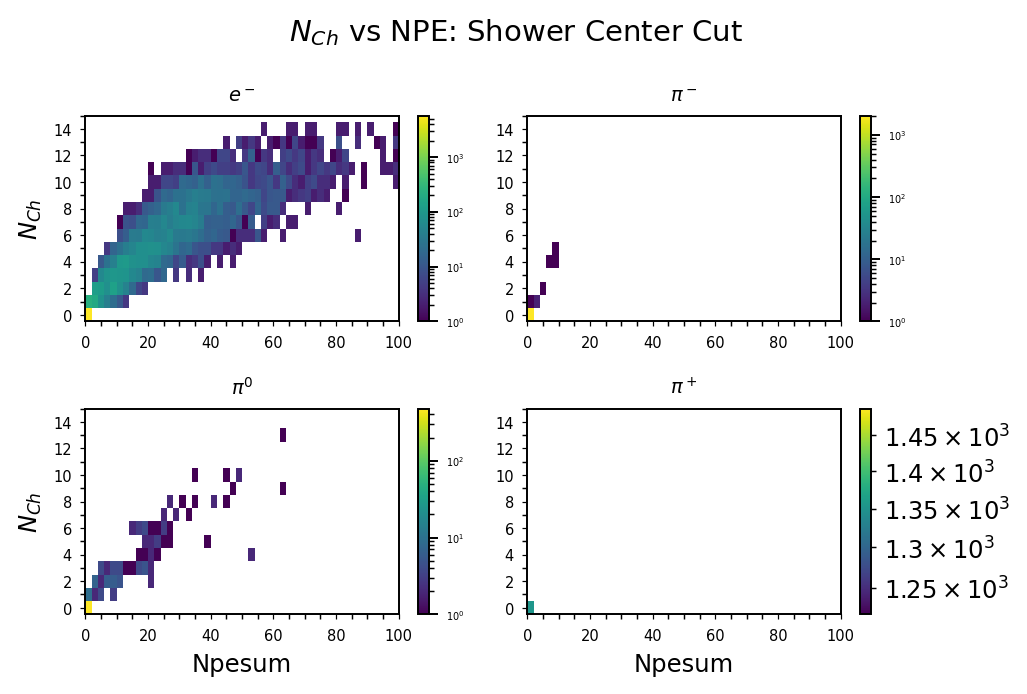

In [101]:
# Loop Over Shower Vals
columns =["Npesum","$N_{Ch}$"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,600),(0,150)],[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,100)]]
bins = [[60,15], [30,8], [60,12], [30,8]]


particles = ["$e^-$", "$\pi^-$", "$\pi^0$", "$\pi^+$"]
part_ids = [11, -211, 111, 211]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("$N_{Ch}$ vs NPE: Shower Center Cut")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8)
    
    keeps = (all_sim["pid"]==part_ids[j]) & ((Clust_x**2 + Clust_y**2)**0.5 < 1)

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(all_sim["Npesum"][keeps], (Cer_array>0).sum(axis=1)[keeps],
                                                         #bins=[np.arange(0,bins[j][0],1),np.arange(0.5,bins[j][1]+.5,1)], 
                                                         bins=[np.arange(0,101,2),np.arange(-0.5,15.5,1)], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    x = np.arange(0,60,1)
    #axes[int(j/2),j%2].plot(x,x)
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,101,5),minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,16,2))
    axes[int(j/2),j%2].set_yticks(np.arange(0,16,1),minor=1)
    #axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/NewCher_NCh_NPE_CenterCut.pdf") 


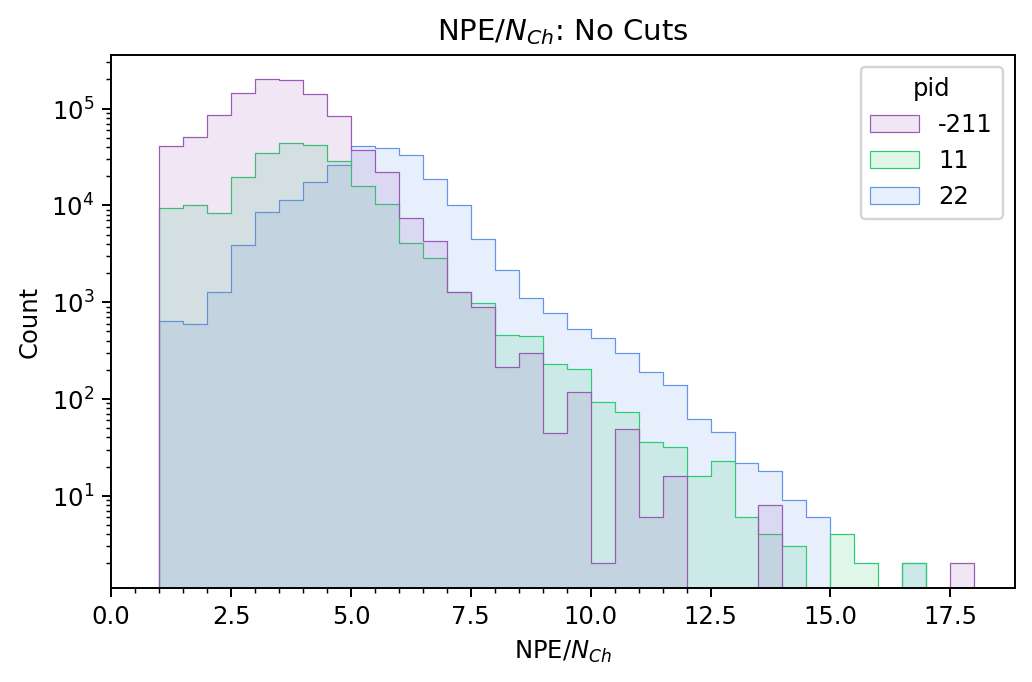

In [57]:
plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: No Cuts")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")

keeps = (all_sim["Npesum"]>0) & ((all_sim["ShowerSum"]<200) | (all_sim["pid"]!=11)) #& ((Clust_x**2 + Clust_y**2)**0.5 < 2)

all_sim["NPE_NCh"] = all_sim["Npesum"]/((Cer_array>0).sum(axis=1)+0.0001)

sns.histplot(all_sim[keeps], x="NPE_NCh", hue="pid", binwidth=.5, element="step", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
#plt.savefig(f"Plots/NewCher_NPE_Per_NCh_NoCuts.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

### Cherenkov Position

In [269]:
((Cher_Array_4x4*x_points)/Cher_Sums[:,None,None]).std(axis=(2,1))

<ipython-input-269-4ccb3f2ee802>:1: RuntimeWarning: invalid value encountered in true_divide
  ((Cher_Array_4x4*x_points)/Cher_Sums[:,None,None]).std(axis=(2,1))


array([0.07094092, 0.06817524,        nan, ..., 0.06865875,        nan,
              nan])

In [323]:
%%time
Cher_Array_4x4 = np.rot90(Cer_array.reshape(len(Cer_array),4,4),axes=(1,2))
Cher_Sums = Cer_array.sum(axis=1)
Cher_Sigmas = Cer_array.std(axis=1)

x_points = np.rot90(np.tile(np.arange(-1.5,1.6,1), (4,1)).T)
Cher_X = (Cher_Array_4x4*x_points).sum(axis=(2,1))/Cher_Sums
Cher_dX = ((Cher_Array_4x4*x_points)).std(axis=(2,1))/Cher_Sigmas

y_points = np.rot90(np.tile(np.arange(-1.5,1.6,1), (4,1)))
Cher_Y = (Cher_Array_4x4*y_points).sum(axis=(2,1))/Cher_Sums
Cher_dY = ((Cher_Array_4x4*y_points)).std(axis=(2,1))/Cher_Sigmas

<timed exec>:6: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:7: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:10: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 146 ms, sys: 230 ms, total: 376 ms
Wall time: 371 ms


<timed exec>:11: RuntimeWarning: invalid value encountered in true_divide


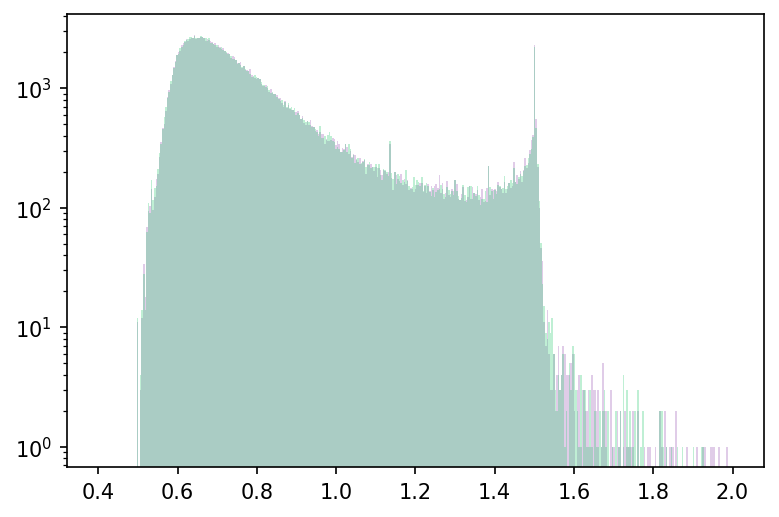

In [332]:
plt.figure(dpi=150)
keeps = (all_sim["pid"]==11) & (all_sim["Npesum"]>0) & (all_sim["NCh"]>1) #& (all_sim["Npesum"]<35)

plt.hist(Cher_dX[keeps], bins=np.linspace(0.4,2,400), 
         alpha=0.3)
plt.hist(Cher_dY[keeps], bins=np.linspace(0.4,2,400), 
         alpha=0.3)
plt.yscale("log")
plt.show()

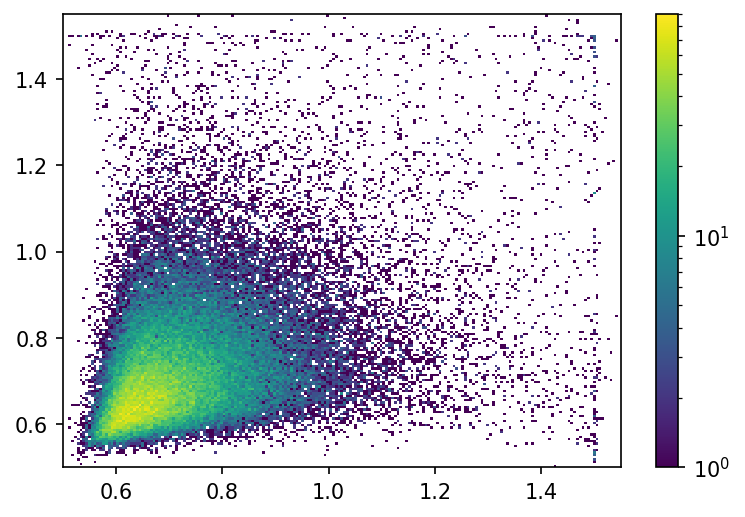

In [349]:
plt.figure(dpi=150)

keeps = (all_sim["pid"]==11) & (all_sim["Npesum"]>0) & (all_sim["NCh"]>1) & ((all_sim["p"]>6)&(all_sim["p"]<40)) 
#& (all_sim["Npesum"]>25) & (all_sim["Npesum"]<35)

plt.hist2d(Cher_dX[keeps], Cher_dY[keeps], 
           bins=(np.linspace(0.5,1.55,200),np.linspace(0.5,1.55,200)),  
           norm=LogNorm())

plt.colorbar()
#Cher_dY)

In [184]:
np.rot90(Cer_array[0].reshape(4,4))

array([[ 0.,  1.,  2.,  0.],
       [ 5.,  5.,  3.,  2.],
       [ 1., 10.,  7.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [185]:
np.rot90(Cer_array.reshape(len(Cer_array),4,4),axes=(1,2))[0]

array([[ 0.,  1.,  2.,  0.],
       [ 5.,  5.,  3.,  2.],
       [ 1., 10.,  7.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [151]:
x, y = np.tile(np.arange(-1.5,1.6,1), (4,1)).T.flatten(), np.tile(np.arange(-1.5,1.6,1), (4,1)).flatten()

Cher_x, Cher_y = ((x*Cer_array).sum(axis=1))/(Cer_array.sum(axis=1)+1e-5), ((y*Cer_array).sum(axis=1))/(Cer_array.sum(axis=1)+1e-5)

In [105]:
np.vstack((Cher_x, Cher_y)).T

array([[ 1.2999974 ,  1.499997  ],
       [ 0.        ,  0.        ],
       [-0.80434748, -1.28260814],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

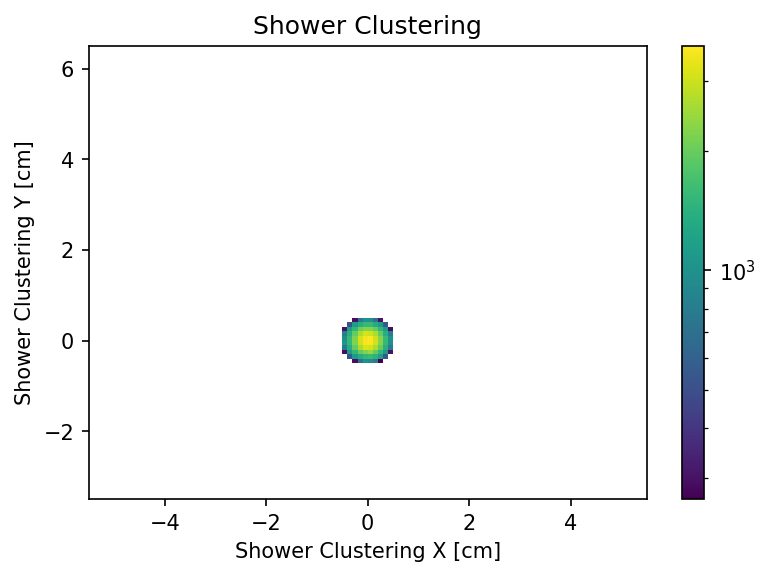

In [225]:
Clust_x, Clust_y, Clust_z = Shower_Clustering(all_sim["Shower_l"],all_sim["Shower_t"],all_sim["Shower_r"])

plt.figure(dpi=150)
plt.title("Shower Clustering")
plt.xlabel("Shower Clustering X [cm]")
plt.ylabel("Shower Clustering Y [cm]")

keeps = ((Clust_x**2 + Clust_y**2)**0.5 < .5)

plt.hist2d(Clust_x[keeps], Clust_y[keeps], norm=LogNorm(), #weights=all_sim["rate"],
           bins=[np.arange(-5.5,5.6,.1),np.arange(-3.5,6.6,.1)])#, range=((-5.5,5.5),(-3.5,6.5)))

plt.colorbar()

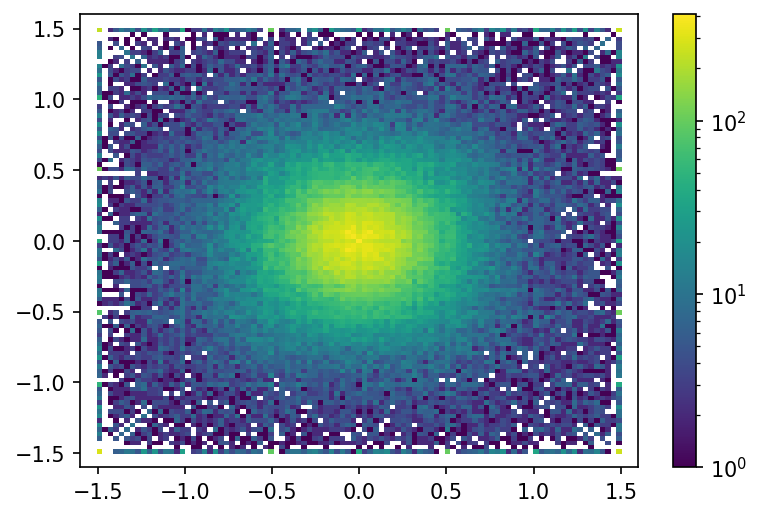

In [320]:
fig, ax = plt.subplots(dpi=150)

keeps = (all_sim["pid"]==11) & (all_sim["Npesum"]>0) #& (((Clust_x-1)**2 + (Clust_y-1)**2)**0.5 < .5)

plt.hist2d(Cher_x[keeps], Cher_y[keeps], norm=LogNorm(), bins=np.linspace(-1.6,1.6,102))
center = plt.Circle((0.2,.2),.5, fill=0, color="cornflowerblue", lw=2)
#ax.add_patch(center)

plt.colorbar()

In [ ]:
### plt.figure(dpi=150)

plt.scatter()


In [34]:
Cer_array[2]

array([8., 1., 0., 0., 8., 4., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
Cer_array

array([[0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [8., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Coincidence

In [33]:
def get_good_array(array):
    #All Combinations - Easier than something fancy
    combos = [[0,1,3,2],
              [1,0,4,6,3,2],
              [2,0,1,3,9,8],
              [3,2,0,1,4,6,12,9,8],
              [4,1,5,7,6,3],
              [5,4,6,7],
              [6,3,1,4,7,5,13,12,9],
              [7,6,4,5,13,12],
              [8,2,3,9,11,10],
              [9,8,2,3,6,12,14,11,10],
              [10,8,9,11],
              [11,10,8,9,12,14],
              [12,9,3,6,7,13,15,14,11],
              [13,12,6,7,15,14],
              [14,11,9,12,13,15],
              [15,14,12,13]]

    #Get Good Entries
    good_entries=[]
    
    #Loop Through Channels
    for n in range(len(combos)):
    #Needs True x At Least One Fired
        good_entries.append((array[:,combos[n][0]]*((array[:,combos[n][1:]].sum(axis=1))>=1)))
    good_array = array*np.array(good_entries).T
    
    return good_array

def get_good_array_sim(array):
    #All Combinations - Easier than something fancy
    combos = [[0,4,1,5],
              [1,5,4,0,2,6],
              [2,6,5,1,3,7],
              [3,7,6,2],
              [4,8,0,1,5,9],
              [5,9,8,4,0,1,2,6,10],
              [6,10,9,5,1,2,3,7,11],
              [7,11,10,6,2,3],
              [8,12,4,5,9,13],
              [9,13,12,8,4,5,6,10,14],
              [10,14,13,9,5,6,7,11,15],
              [11,15,14,10,6,7],
              [12,8,9,13],
              [13,12,8,9,10,14],
              [14,13,9,10,11,15],
              [15,14,10,11]]

    #Get Good Entries
    good_entries=[]
    
    #Loop Through Channels
    for n in range(len(combos)):
    #Needs True x At Least One Fired
        good_entries.append((array[:,combos[n][0]]*((array[:,combos[n][1:]].sum(axis=1))>=1)))
    good_array = array*np.array(good_entries).T
    
    return good_array



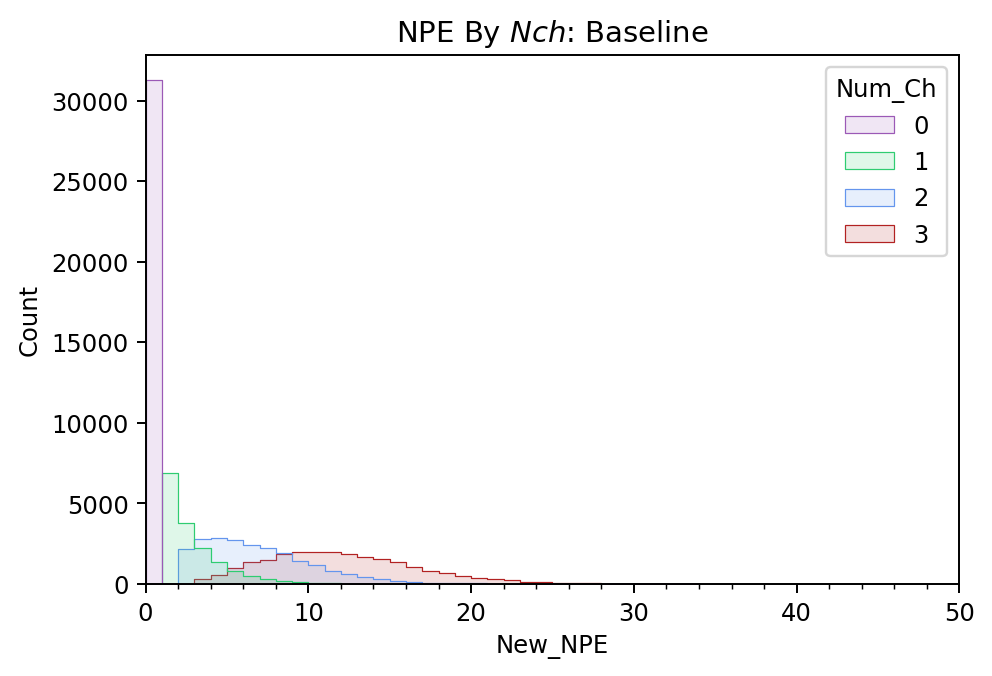

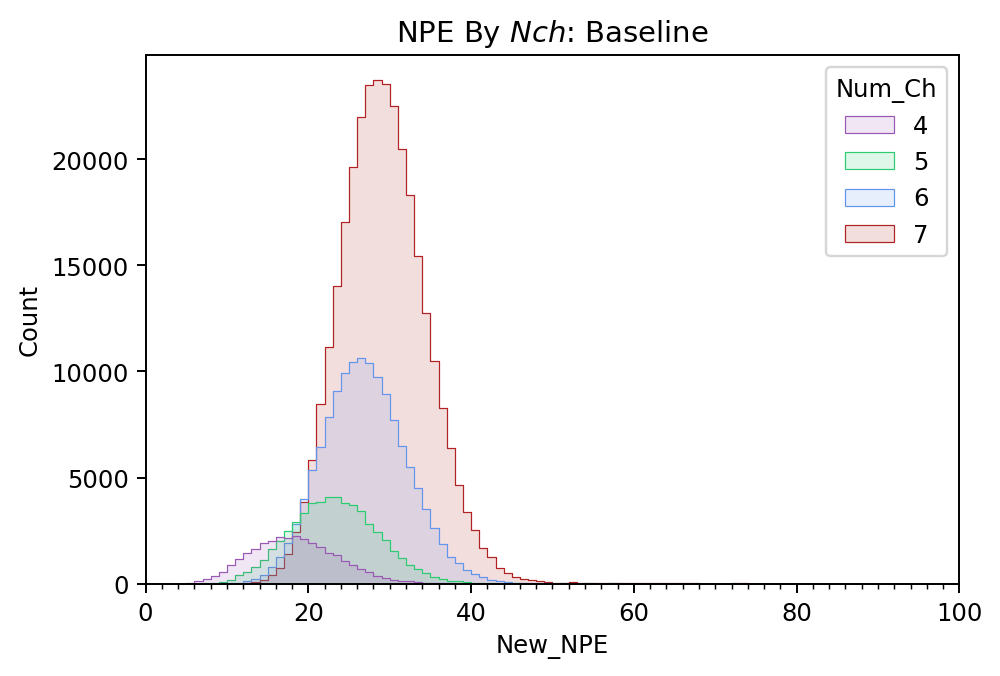

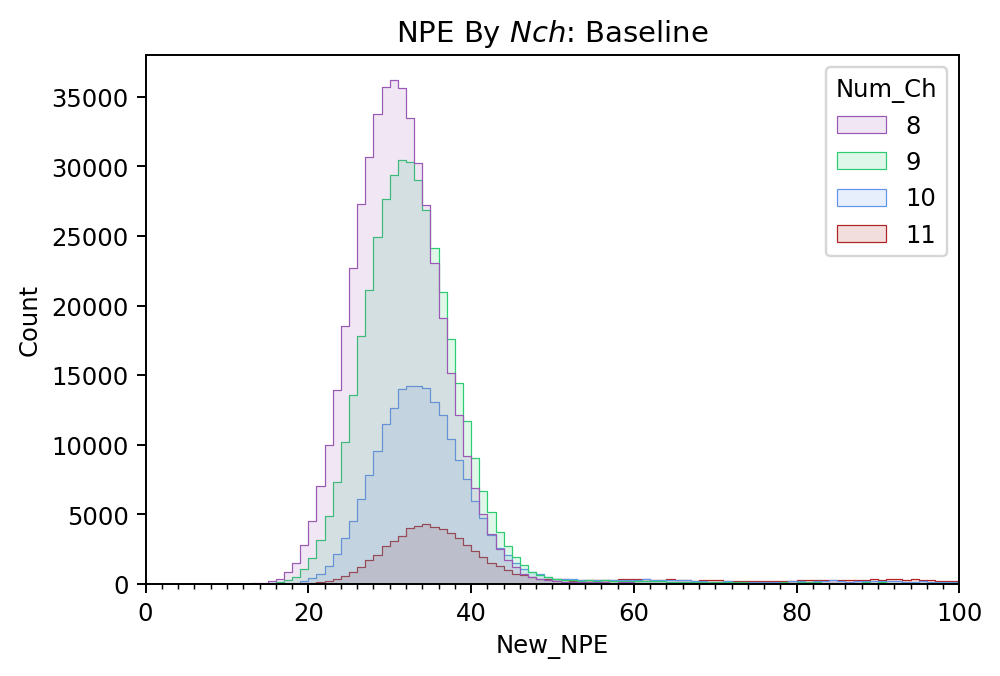

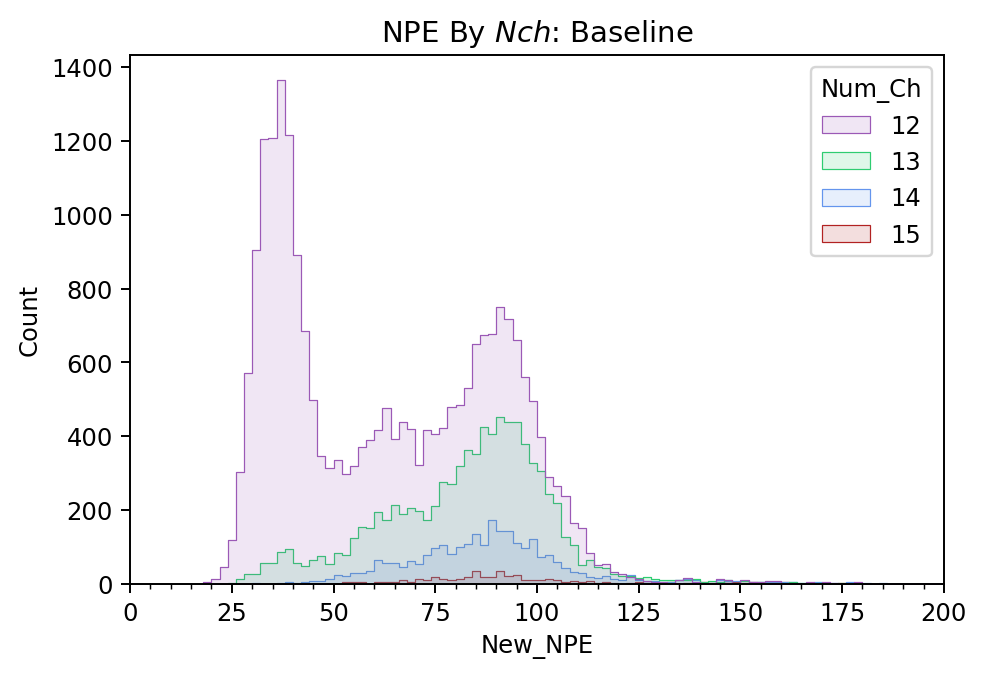

In [47]:
#triggers = [8,4,1]
#keeps = np.isin(raw_data_df["TrigType"],triggers)

#Scale & Get Keeps
channel_bool_val = (Cer_array > 0) 
keeps = (sim_df["pid"]==11)

plot_data = pd.DataFrame({'New_NPE':((Cer_array)).sum(axis=1).flatten(), 
                          'Num_Ch':(Cer_array>0).sum(axis=1)})

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=0) & (plot_data["Num_Ch"]<=3) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.15, linewidth=0.5)
#plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,50+1,2), minor=True)

plt.savefig(f"Plots/NewCher_NPE_ByChannel.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=4) & (plot_data["Num_Ch"]<=7) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.15, linewidth=0.5)
#plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,100+1,2), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=8) & (plot_data["Num_Ch"]<=11) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.15, linewidth=0.5)
#plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,100+1,2), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=12) & (plot_data["Num_Ch"]<=15) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=2, alpha=0.15, linewidth=0.5)
#plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,200+1,5), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()


In [37]:
best_colors[0:1]+best_colors[2:]

['#9b59b6', '#2ecc71', 'cornflowerblue', 'firebrick']

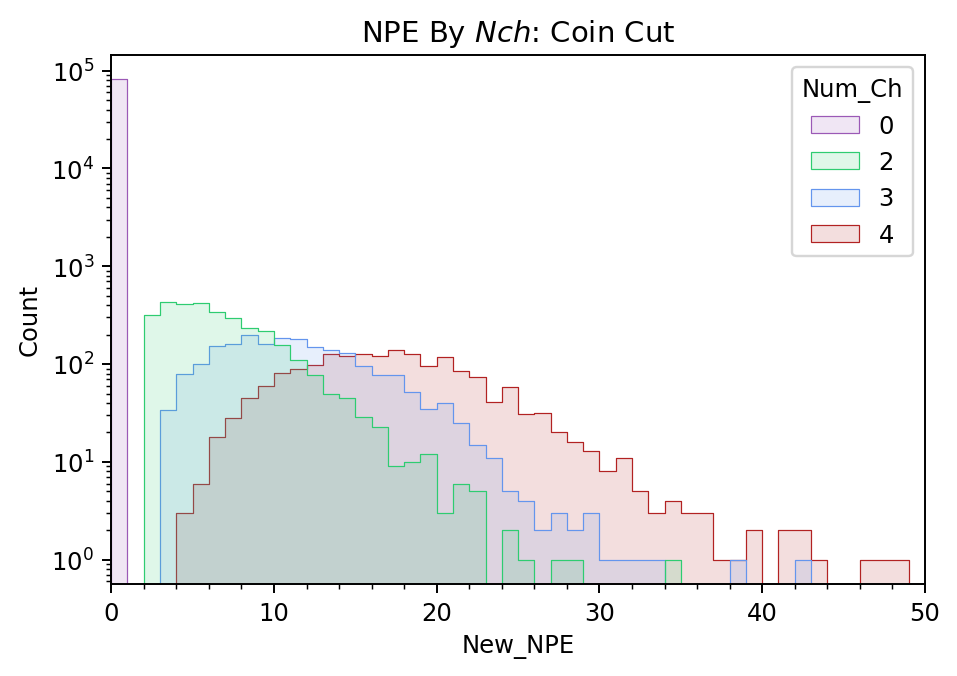

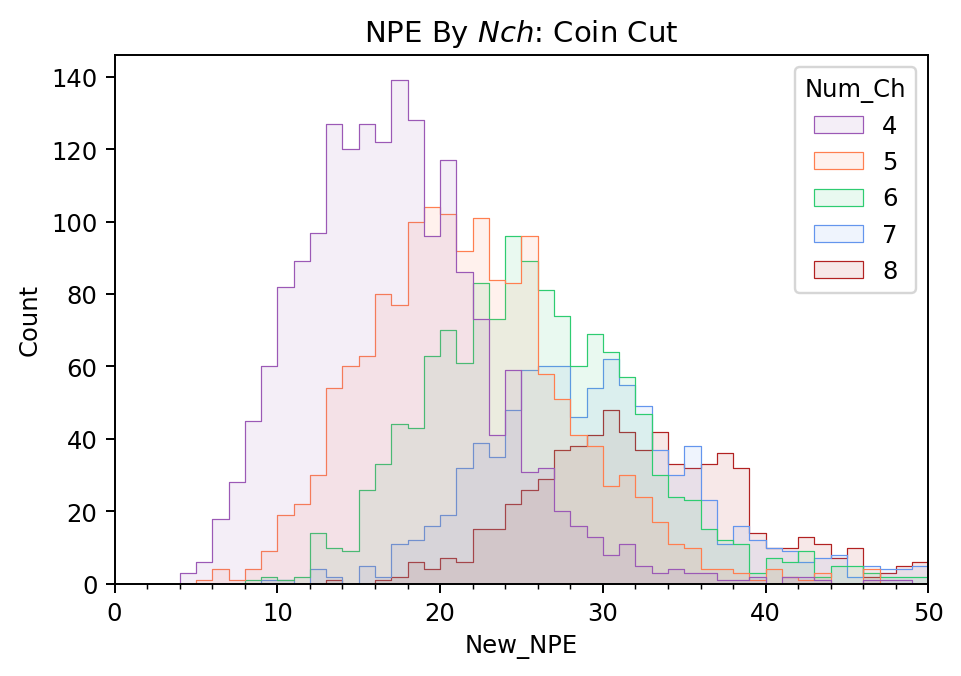

In [38]:
#triggers = [8,4,1]
#keeps = np.isin(raw_data_df["TrigType"],triggers)

#Scale & Get Keeps
channel_bool_val = (Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1)})

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Coin Cut")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=-1) & (plot_data["Num_Ch"]<=4)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors[0:1]+best_colors[2:]), 
             binwidth=1, alpha=0.15, linewidth=0.5)
plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,50+1,2), minor=True)

plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Coin Cut")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=4) & (plot_data["Num_Ch"]<=8)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.1, linewidth=0.5)
#plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,50+1,2), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()


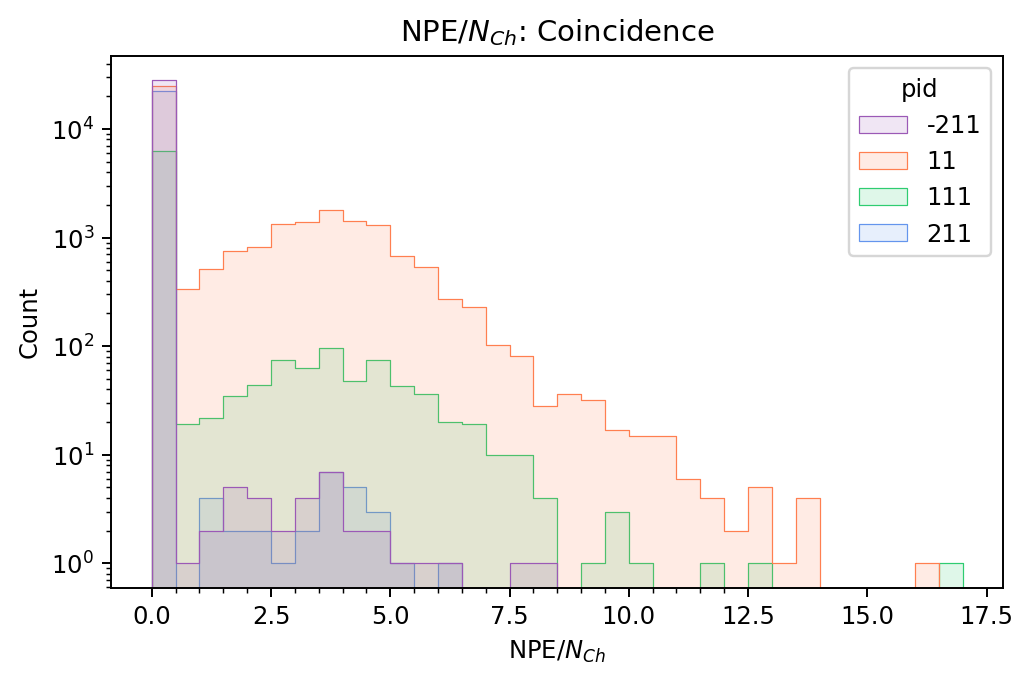

In [43]:
plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: Coincidence")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")

channel_bool_val = (Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1),
                          'pid':sim_df["pid"]})

plot_data["NPE_NCh"] = plot_data["New_NPE"]/(plot_data["Num_Ch"]+0.0001)

keeps = (sim_df["ShowerSum"]>-200)

sns.histplot(plot_data[keeps], x="NPE_NCh", hue="pid", binwidth=.5, element="step", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
plt.savefig(f"Plots/NewCher_NPE_Per_NCh_Coin.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

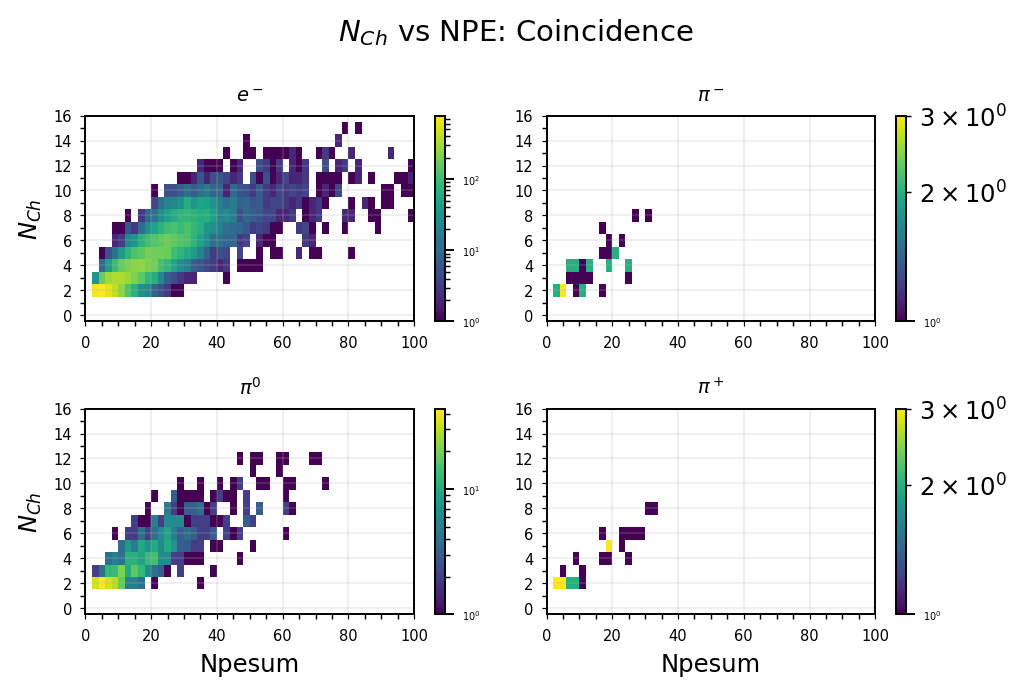

In [44]:
# Loop Over Shower Vals
columns =["Npesum","$N_{Ch}$"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,600),(0,150)],[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,100)]]
bins = [[60,15], [30,8], [60,12], [30,8]]


particles = ["$e^-$", "$\pi^-$", "$\pi^0$", "$\pi^+$"]
part_ids = [11, -211, 111, 211]

p_scaling = 1


channel_bool_val = (Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1),
                          'pid':sim_df["pid"]})



fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("$N_{Ch}$ vs NPE: Coincidence")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8)
    
    keeps = (plot_data["pid"]==part_ids[j]) & (plot_data["New_NPE"]>0) #& ((sim_df["ShowerSum"]>200) | (plot_data["pid"]!=11)) #HE electron cut

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_data["New_NPE"][keeps], plot_data["Num_Ch"][keeps],
                                                         #bins=[np.arange(0,bins[j][0],1),np.arange(0.5,bins[j][1]+.5,1)], 
                                                         bins=[np.arange(0,101,2),np.arange(-0.5,16.5,1)], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    x = np.arange(0,60,1)
    #axes[int(j/2),j%2].plot(x,x)
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,101,5),minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,17,2))
    axes[int(j/2),j%2].set_yticks(np.arange(0,17,1),minor=1)
    #axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
    axes[int(j/2),j%2].grid(alpha=0.2)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/NewCher_NCh_NPE_Coin.pdf") 


## Pseudo-Triggers

In [15]:
#MIP Peak Values
Scint_MIPs = [1.65, 1.65, 3.5, 3.5]
Shower_MIP = 37.5#[37.5,37.5,37.5,37.5]

#Assuming SC-threshold @ half-MIP to start, then will get more precise values later

#TS1 - CherSum
TS1_Sim = all_sim[all_sim["Npesum"]>=2].copy()
TS1_Sim["Trig"] = "TS1"

#TS2 - SC-B & SC-D
TS2_Sim = all_sim[(all_sim["SC_B_Eendsum"]>Scint_MIPs[1]/2) & (all_sim["SC_D_Eendsum"]>Scint_MIPs[3]/2)].copy()
TS2_Sim["Trig"] = "TS2"

#TS3 - SC-C & SC-D & ShowerSum (ShSum val is an estimate)
TS3_Sim = all_sim[(all_sim["SC_C_Eendsum"]>Scint_MIPs[2]/2) & (all_sim["SC_D_Eendsum"]>Scint_MIPs[3]/2) & (all_sim["ShowerSum"]>15)].copy()
TS3_Sim["Trig"] = "TS3"

#TS4 - ShowerSum 
TS4_Sim = all_sim[all_sim["ShowerSum"]>200].copy()
TS4_Sim["Trig"] = "TS4"

#Combine
Trig_Sim = TS1_Sim.append([TS2_Sim,TS3_Sim,TS4_Sim])
Trig_Sim

,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta,NCh,Trig
0,0.000261,0.212364,0.047032,4.135960,-0.875710,0.006042,2.66734,2.807420,11,0.000000,...,[],0.000000,0.000000,0.000000,0.000000,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.175845,2,TS1
2,0.000370,-0.128510,-0.117401,0.500567,-0.574820,-0.002970,1.78003,1.870544,11,1830.968872,...,"[-670.5233764648438, -670.750244140625, -675.0...",0.002258,0.002258,0.002258,0.031919,23.0,"[8.0, 1.0, 0.0, 0.0, 8.0, 4.0, 0.0, 0.0, 2.0, ...",17.896899,5,TS1
4,0.000190,0.036881,0.068365,-3.156610,-1.254460,-0.000594,3.88418,4.081730,11,4071.276611,...,"[-670.0872802734375, -669.8561401367188]",0.000967,0.000967,0.000967,0.020122,29.0,"[0.0, 4.0, 11.0, 2.0, 0.0, 5.0, 6.0, 1.0, 0.0,...",17.898709,6,TS1
5,0.000190,-0.179174,0.113327,-2.168040,-1.264350,0.009848,3.92927,4.127692,11,0.000000,...,[-671.216064453125],0.000000,0.000000,0.000000,0.000000,12.0,"[0.0, 0.0, 1.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17.837515,2,TS1
13,0.000254,0.094947,0.005353,1.726020,-0.942165,0.008594,2.89119,3.040843,11,0.000000,...,[-671.0243530273438],0.000000,0.000000,0.000000,0.000000,7.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, ...",18.050168,2,TS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43313,2.096245,0.066167,-0.040340,-0.716216,-0.829929,-0.003734,2.55594,2.687308,-211,2681.831787,...,"[-673.3743286132812, -669.8782958984375]",0.019789,0.019789,0.019789,5.771978,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.989096,0,TS4
43420,2.095492,-0.092468,0.196380,-3.208640,-0.802055,-0.000241,2.49484,2.620595,-211,2616.338623,...,[-668.0147094726562],0.000057,0.000057,0.000057,0.112972,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.821844,0,TS4
43878,2.098754,0.119042,0.189024,-2.803890,-1.137980,-0.009401,3.50945,3.689353,-211,0.000000,...,[],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.966457,0,TS4
44936,2.092417,-0.111480,0.039445,2.154820,-0.587686,0.000497,1.80266,1.896037,-211,1892.355225,...,[-674.717529296875],0.014658,0.014658,0.014658,0.096409,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.056515,0,TS4


(-32.37425994873047, 700.0)

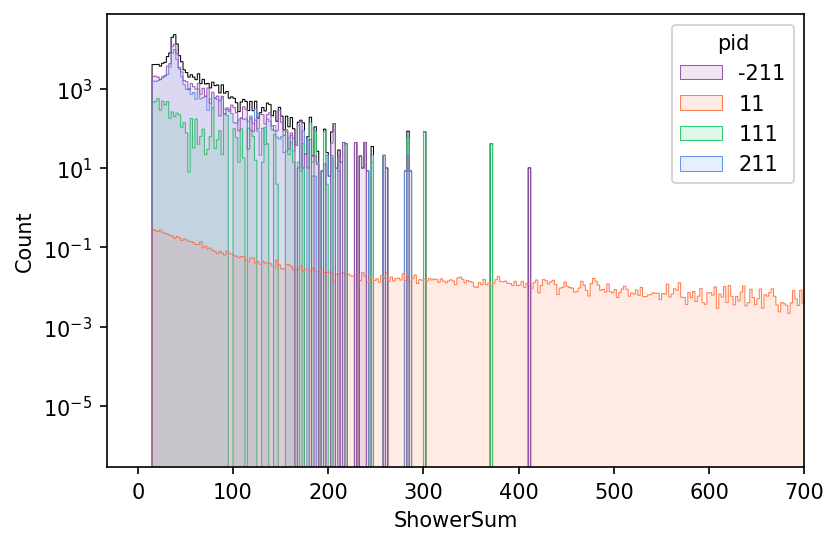

In [24]:
plt.figure(dpi=150)
sns.histplot(TS3_Sim, x="ShowerSum", binwidth=2.5, element="step", weights="rate", 
             alpha=0, linewidth=0.5, color="black")

sns.histplot(TS3_Sim, x="ShowerSum", hue="pid", binwidth=2.5, element="step", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
plt.xlim(right=700)

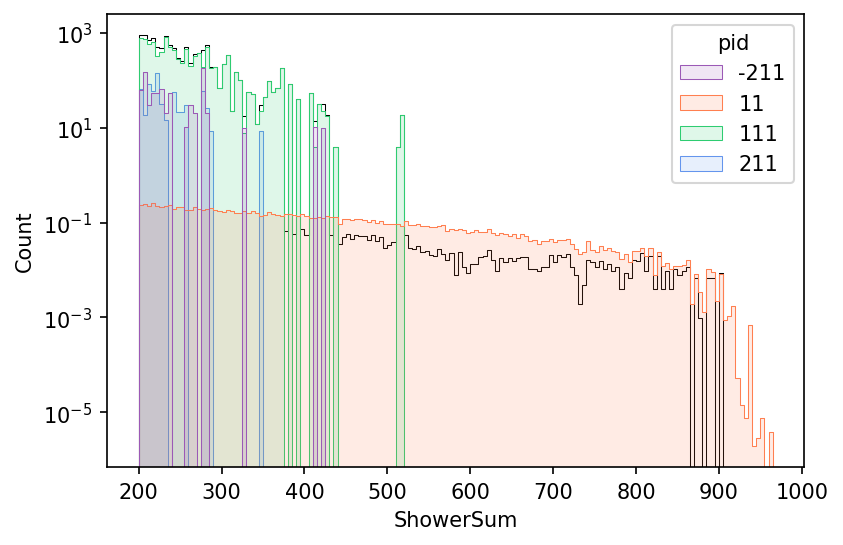

In [20]:
#TS4 - ShowerSum 
TS4_Sim = all_sim[all_sim["ShowerSum"]>200].copy()
TS4_Sim["Trig"] = "TS4"

plt.figure(dpi=150)
sns.histplot(TS4_Sim, x="ShowerSum", binwidth=5, element="step", #weights="rate", 
             alpha=0, linewidth=0.5, color="black")

sns.histplot(TS4_Sim, x="ShowerSum", hue="pid", binwidth=5, element="step", #weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(right=700)

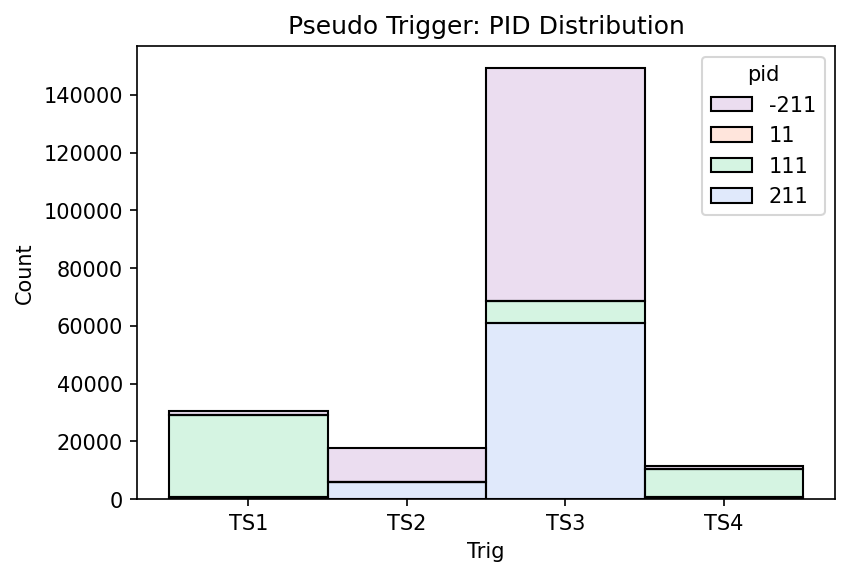

In [16]:
plt.figure(dpi=150)
plt.title("Pseudo Trigger: PID Distribution")
sns.histplot(Trig_Sim, x="Trig", hue="pid", binwidth=.5, multiple="stack", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.2)

#plt.yscale("log")
#plt.yticks(np.arange(0,16000+1,500),minor=1)

plt.show()

### Trigger Cher


In [17]:
%%time

channel_list = [[] for _ in range(16)]
    
for row in Trig_Sim["Cer"]:#[data0["TrigType"] == 32]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Trig_Cer_array = np.array(channel_list).T

CPU times: user 2.7 s, sys: 139 ms, total: 2.84 s
Wall time: 2.83 s


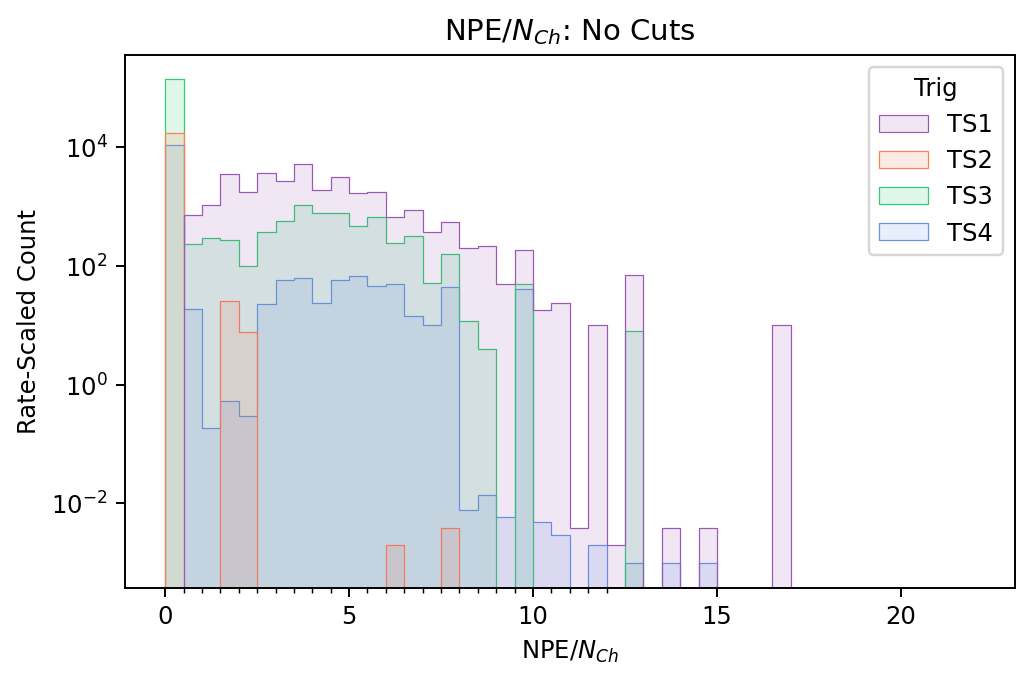

In [68]:
plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: No Cuts")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")
plt.ylabel("Rate-Scaled Count")

keeps = (Trig_Sim["Npesum"]>-10) #& ((sim_df["ShowerSum"]>200) | (sim_df["pid"]!=11)) & ((Clust_x**2 + Clust_y**2)**0.5 < 2)

Trig_Sim["NPE_NCh"] = Trig_Sim["Npesum"]/((Trig_Cer_array>0).sum(axis=1)+0.0001)

sns.histplot(Trig_Sim[keeps], x="NPE_NCh", hue="Trig", binwidth=.5, element="step", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
plt.savefig(f"Plots/NewCher_Trig_NPE_Per_NCh_NoCuts.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

In [69]:
channel_bool_val = (Trig_Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Trig_Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1),
                          'Trig':Trig_Sim["Trig"],
                          'rate':Trig_Sim["rate"]})

plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: Coincidence")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")
plt.ylabel("Rate-Scaled Count")

keeps = (plot_data["New_NPE"]>-10) #& ((sim_df["ShowerSum"]>200) | (sim_df["pid"]!=11)) & ((Clust_x**2 + Clust_y**2)**0.5 < 2)

plot_data["NPE_NCh"] = plot_data["New_NPE"]/(plot_data["Num_Ch"]+0.0001)

sns.histplot(plot_data[keeps], x="NPE_NCh", hue="Trig", binwidth=.5, element="step", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
plt.savefig(f"Plots/NewCher_Trig_NPE_Per_NCh_Coin.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

NameError: name 'get_good_array_sim' is not defined